# 50. Make megasheet
This is based on earlier 50 notebook where we first attempted to merge in all regulatory info BEFORE merging cor, heritability and GWAS results, which is inefficient. We wont' focus on regulatory info in this one. Here, we want to get together everything we need to make sure we can find A) How may old GWAS associations are explained by our MWAS; and B) How many of our MWAS associations are novel

Old:
file needed: 
Nott Core
unique pos
DNAm
chainfile
liftover bin
bedtools bin

In original version, we only brought in heritability from ALL now we also include heritability for EA and AA

## 0-7 up through liftover of regulatory features

In [1]:
setwd("/dcs05/lieber/hanlab/mnagle/mwas/CpGWAS/scripts/")

In [2]:
# # Filename: full_workflow_with_liftover_and_DNAm.R
# # Purpose: Process Excel sheets, additional BED files, GWAS hits, GTF features,
# #          perform liftover on specific data, combine BED files, intersect with unique positions,
# #          and integrate DNA methylation data.

# # ===============================
# # 0. Load Necessary Libraries
# # ===============================
# suppressPackageStartupMessages({
#   library(openxlsx)    # For reading Excel files
#   library(data.table)  # For efficient data manipulation
#   library(tools)       # For file path operations
# })

# # ===============================
# # Helper Function: Timestamped Messages
# # ===============================
# log_message <- function(message) {
#   cat(sprintf("[%s] %s\n", format(Sys.time(), "%Y-%m-%d %H:%M:%S"), message))
# }

In [3]:
# # ===============================
# # 1. Process Excel Sheets
# # ===============================
# log_message("Starting processing of Excel sheets.")

# # Define the path to the Excel file
# nott_file <- "/dcs05/lieber/hanlab/mnagle/mwas/CpGWAS/scripts/42.8-IN_Nott_interactome/aay0793-Nott-Table-S5.xlsx"  # Update the path if necessary

# # Check if the Excel file exists
# if(!file.exists(nott_file)){
#   stop(paste("Excel file not found at path:", nott_file))
# }

# # List all sheet names in the Excel file
# sheet_names <- getSheetNames(nott_file)

# # Print all sheet names
# log_message("Sheet Names:")
# cat(paste(sheet_names, collapse = "\n"), "\n\n")

# # Initialize a list to store processed sheets
# processed_sheets <- list()

# # Loop through each sheet to process
# for (sheet in sheet_names) {
#   log_message(paste("Processing Sheet:", sheet))
  
#   # Read the sheet with headers, starting from row 3
#   sheet_data <- tryCatch({
#     read.xlsx(nott_file, sheet = sheet, startRow = 3, colNames = TRUE)
#   }, error = function(e){
#     stop(paste("Failed to read sheet:", sheet, "\nError:", e$message))
#   })
  
#   # Convert to data.table for easier handling
#   sheet_dt <- as.data.table(sheet_data)
  
#   # Ensure the first three columns are Chromosome, Start, End
#   required_cols <- c("Chromosome", "Start", "End")
#   missing_cols <- setdiff(required_cols, names(sheet_dt))
#   if (length(missing_cols) > 0) {
#     stop(paste("Error in sheet:", sheet, "- Missing required columns:", 
#                paste(missing_cols, collapse = ", ")))
#   }
  
#   # Check if the first three columns are exactly Chromosome, Start, End
#   actual_first_three <- names(sheet_dt)[1:3]
#   if (!all(actual_first_three == required_cols)) {
#     stop(paste("Error in sheet:", sheet, 
#                "- The first three columns must be Chromosome, Start, End."))
#   }
  
#   # Identify additional columns beyond the first three
#   additional_cols <- setdiff(names(sheet_dt), required_cols)
  
#   if (length(additional_cols) == 0) {
#     # If no additional columns, INFO is just the sheet name
#     sheet_dt[, INFO := gsub(" ", "_", sheet)]
#     log_message("No additional columns. INFO column set to sheet name with underscores.")
#   } else {
#     # Concatenate additional columns into INFO
#     # Replace spaces with underscores to prevent splitting
#     # Format: "SheetName_|_Column4:_Value4;_Column5:_Value5;_..."
#     sheet_dt[, INFO := paste0(
#       gsub(" ", "_", sheet), "|",
#       apply(.SD, 1, function(row) {
#         paste(paste0(gsub(" ", "_", names(.SD)), ":", gsub(" ", "_", row)), collapse = ";")
#       })
#     ), .SDcols = additional_cols]
    
#     log_message("Added INFO column by concatenating additional columns with underscores.")
#   }
  
#   # Retain only Chromosome, Start, End, INFO columns
#   final_cols <- c("Chromosome", "Start", "End", "INFO")
#   sheet_dt <- sheet_dt[, ..final_cols]
  
#   # Ensure Start and End are integers
#   sheet_dt[, Start := as.integer(Start)]
#   sheet_dt[, End := as.integer(End)]
  
#   # Print the first five rows of the processed sheet
#   log_message("First 5 rows of processed sheet:")
#   print(head(sheet_dt, 5))
  
#   # Store the processed sheet in the list
#   processed_sheets[[sheet]] <- sheet_dt
  
#   log_message(paste("Completed processing of sheet:", sheet, "\n"))
# }

# log_message("Completed processing of Excel sheets.\n")

# # ===============================
# # 2. Process Additional BED Files
# # ===============================
# log_message("Starting processing of additional BED files.")

# # Define the path to the directory containing additional BED files
# additional_bed_dir <- "/dcs05/lieber/hanlab/mnagle/mwas/CpGWAS/scripts/47-IN_annotation_regulatory_regions/15core/"  # Update if necessary

# # Check if the directory exists
# if(!dir.exists(additional_bed_dir)){
#   stop(paste("Additional BED files directory not found at path:", additional_bed_dir))
# }

# # List all BED files in the directory
# all_bed_files <- list.files(additional_bed_dir, pattern = "\\.bed\\.gz$", full.names = TRUE)

# # Print all BED files found
# log_message("All BED Files Found:")
# cat(paste(all_bed_files, collapse = "\n"), "\n\n")

# # Define the brain regions and their corresponding IDs to include
# brain_sample_ids_all <- data.frame(
#   ID = c("E071", "E074", "E068", "E069", "E072", "E067", "E073", "E070", "E082", "E081"),
#   Region = c("Hippocampus_Middle", "Substantia_Nigra", "Anterior_Caudate", 
#              "Cingulate_Gyrus", "Inferior_Temporal_Lobe", "Angular_Gyrus",
#              "Dorsolateral_Prefrontal_Cortex", "Germinal_Matrix",
#              "Fetal_Brain_Female", "Fetal_Brain_Male"),
#   stringsAsFactors = FALSE
# )

# # Define the brain regions we want to include
# desired_brain_ids <- c("E071", "E068", "E073")
# desired_brain_regions <- brain_sample_ids_all$Region[brain_sample_ids_all$ID %in% desired_brain_ids]

# # Filter BED files for desired brain regions based on filenames containing the IDs
# # Assuming filenames contain the IDs like 'E071', 'E068', 'E073'
# filtered_bed_files <- all_bed_files[grepl(paste(desired_brain_ids, collapse = "|"), all_bed_files)]

# # Print the filtered BED files
# log_message("Filtered BED Files for Desired Brain Regions:")
# cat(paste(filtered_bed_files, collapse = "\n"), "\n\n")

# # Initialize a list to store processed additional BED files
# processed_additional_sheets <- list()

# # Loop through each filtered BED file to process
# for(file in filtered_bed_files){
  
#   log_message(paste("Processing File:", basename(file)))
  
#   # Read the BED file; fread can handle gzipped files
#   file_in <- tryCatch({
#     fread(cmd = paste0("zcat ", shQuote(file)), header = FALSE)
#   }, error = function(e){
#     stop(paste("Failed to read BED file:", file, "\nError:", e$message))
#   })
  
#   # Check if the file has at least 4 columns
#   if(ncol(file_in) < 4){
#     stop(paste("Error in file:", file, "- Expected at least 4 columns (Chromosome, Start, End, Feature)."))
#   }
  
#   # Assign column names
#   setnames(file_in, c("Chromosome", "Start", "End", "Feature"))
  
#   # Ensure Start and End are integers
#   file_in[, Start := as.integer(Start)]
#   file_in[, End := as.integer(End)]
  
#   # Create the INFO column in the desired format
#   # Extract the base filename without extension for clarity
#   file_base <- file_path_sans_ext(basename(file))
#   file_base <- file_path_sans_ext(file_base)  # Remove .bed if present
  
#   # Replace spaces with underscores in Feature to prevent splitting
#   sanitized_feature <- gsub(" ", "_", file_in$Feature)
  
#   # Replace spaces with underscores in file_base to prevent splitting
#   sanitized_file_base <- gsub(" ", "_", file_base)
  
#   file_in[, INFO := paste0(sanitized_file_base, "|feature:", sanitized_feature)]
  
#   # Retain only the relevant columns
#   final_cols <- c("Chromosome", "Start", "End", "INFO")
#   file_in <- file_in[, ..final_cols]
  
#   # Print the first five rows of the processed file
#   log_message("First 5 rows of processed BED file:")
#   print(head(file_in, 5))
  
#   # Store the processed data in the list
#   processed_additional_sheets[[file_base]] <- file_in
  
#   log_message(paste("Completed processing of file:", basename(file), "\n"))
# }

# log_message("Completed processing of additional BED files.\n")

# # ===============================
# # 3. Process GWAS Hits
# # ===============================
# log_message("Starting processing of GWAS hits.")

# # Define the path to the directory containing GWAS files
# gwas_dir <- "/dcs05/lieber/hanlab/mnagle/mwas/gwas/"  # Update if necessary

# # Check if the GWAS directory exists
# if(!dir.exists(gwas_dir)){
#   stop(paste("Error: GWAS files directory not found at path:", gwas_dir))
# }

# # List all GWAS files with pattern 'a3' in their filenames
# gwas_files <- list.files(gwas_dir, pattern = "a3", full.names = TRUE)

# # Check if any GWAS files were found
# if(length(gwas_files) == 0){
#   stop(paste("Error: No GWAS files found in directory:", gwas_dir, "with pattern 'a3'. Please verify the directory path and filename pattern."))
# }

# # Log the GWAS files found
# log_message(paste("Number of GWAS files found:", length(gwas_files)))
# log_message("GWAS Files Found:")
# cat(paste(gwas_files, collapse = "\n"), "\n\n")

# # Initialize a list to store processed GWAS BED entries
# processed_gwas_bed <- list()

# # Loop through each GWAS file to process
# for(file in gwas_files){
  
#   log_message(paste("Processing GWAS File:", basename(file)))
  
#   # Read the GWAS file
#   gwas_dt <- tryCatch({
#     fread(file)
#   }, error = function(e){
#     stop(paste("Failed to read GWAS file:", file, "\nError:", e$message))
#   })

#   # Rename PVAL column to P if necessary
#   if("PVAL" %in% colnames(gwas_dt)){
#       setnames(gwas_dt, "PVAL", "P")
#   }

#   # Ensure necessary columns are present
#   required_gwas_cols <- c("CHR", "BP", "P", "SNP", "A1", "A2")
#   missing_gwas_cols <- setdiff(required_gwas_cols, names(gwas_dt))
#   if(length(missing_gwas_cols) > 0){
#     stop(paste("Error in GWAS file:", file, "- Missing required columns:", 
#                paste(missing_gwas_cols, collapse = ", ")))
#   }
  
#   # Compute Bonferroni threshold
#   bonferroni_threshold <- 0.05 / nrow(gwas_dt)
#   log_message(paste("Computed Bonferroni threshold:", bonferroni_threshold))
  
#   # Filter rows where P <= threshold
#   significant_gwas <- gwas_dt[P <= bonferroni_threshold]
#   log_message(paste("Number of significant GWAS hits:", nrow(significant_gwas)))
  
#   if(nrow(significant_gwas) == 0){
#     stop(paste("Error: No significant GWAS hits found in file:", file))
#   }
  
#   # Define 1MB regions (500kb on each side)
#   significant_gwas[, Start := pmax(0, BP - 500000)]
#   significant_gwas[, End := BP + 500000]
  
#   # Assign Chromosome names with 'chr' prefix if not already present
#   significant_gwas[, Chromosome := ifelse(grepl("^chr", CHR, ignore.case = TRUE),
#                                          CHR,
#                                          paste0("chr", CHR))]
  
#   # Ensure Start and End are integers
#   significant_gwas[, Start := as.integer(Start)]
#   significant_gwas[, End := as.integer(End)]
  
#   # Create INFO column
#   file_base <- file_path_sans_ext(basename(file))
#   file_base <- file_path_sans_ext(file_base)  # Remove .txt if present
  
#   # Replace spaces with underscores in SNP and other fields to prevent splitting
#   significant_gwas[, SNP := gsub(" ", "_", SNP)]
#   significant_gwas[, A1 := gsub(" ", "_", A1)]
#   significant_gwas[, A2 := gsub(" ", "_", A2)]
  
#   # Replace spaces with underscores in file_base to prevent splitting
#   sanitized_file_base <- gsub(" ", "_", file_base)
  
#   significant_gwas[, INFO := paste0(
#     sanitized_file_base, "|Position:", BP, ";A1:", A1, ";A2:", A2, ";SNP:", SNP
#   )]
  
#   # Create BED data.table
#   bed_gwas <- significant_gwas[, .(Chromosome, Start, End, INFO)]
  
#   # Check if BED data is not empty
#   if(nrow(bed_gwas) == 0){
#     stop(paste("Error: Processed GWAS BED data is empty for file:", file))
#   }
  
#   # Print the first five rows of the processed GWAS BED
#   log_message("First 5 rows of processed GWAS BED:")
#   print(head(bed_gwas, 5))
  
#   # Store in the list
#   processed_gwas_bed[[file_base]] <- bed_gwas
  
#   log_message(paste("Completed processing of GWAS file:", basename(file), "\n"))
# }

# log_message("Completed processing of GWAS hits.\n")

# # ===============================
# # 4. Process GTF Features
# # ===============================
# log_message("Starting processing of GTF features.")

# # Define the path to the GTF file
# gtf_file <- "gencode.v38.annotation.gtf"  # Update the path if necessary

# # Check if GTF file exists
# if(!file.exists(gtf_file)){
#   stop(paste("GTF file not found at path:", gtf_file))
# }

# # Read the GTF file
# # GTF files are tab-separated and may have comment lines starting with '#'
# gtf_dt <- tryCatch({
#   fread(cmd = paste("grep -v '^#'", shQuote(gtf_file)), sep = "\t", header = FALSE, fill = TRUE, quote = "")
# }, error = function(e){
#   stop(paste("Failed to read GTF file:", gtf_file, "\nError:", e$message))
# })

# # Assign column names as per GTF specification
# setnames(gtf_dt, c("Chromosome", "Source", "Feature", "Start", "End", "Score", "Strand", "Frame", "Attributes"))

# # Ensure Start and End are integers
# gtf_dt[, Start := as.integer(Start)]
# gtf_dt[, End := as.integer(End)]

# # Create INFO column with Strand and Attribute
# # Replace spaces with underscores in Attributes to prevent splitting
# gtf_dt[, INFO := paste0("Strand:", Strand, ";Attribute:", gsub(" ", "_", Attributes))]

# # Create BED entries
# bed_gtf <- gtf_dt[, .(Chromosome, Start, End, INFO)]

# # Print the first five rows of the processed GTF BED
# log_message("First 5 rows of processed GTF BED:")
# print(head(bed_gtf, 5))

# log_message("Completed processing of GTF features.\n")

# # ===============================
# # 5. Combine All Processed BED Data
# # ===============================
# log_message("Combining all processed BED data into separate data tables.")

# # Combine processed Excel sheets (needs liftover)
# if(length(processed_sheets) > 0){
#   excel_bed_combined <- rbindlist(processed_sheets, use.names = TRUE, fill = TRUE)
#   log_message("Combined Excel-derived BED data.")
# } else {
#   excel_bed_combined <- NULL
#   warning("No processed Excel sheets to combine.")
# }

# # Combine processed additional BED files (needs liftover)
# if(length(processed_additional_sheets) > 0){
#   additional_bed_combined <- rbindlist(processed_additional_sheets, use.names = TRUE, fill = TRUE)
#   log_message("Combined additional BED files.")
# } else {
#   additional_bed_combined <- NULL
#   warning("No processed additional BED files to combine.")
# }

# # Combine processed GWAS BED files (already hg38, no liftover)
# if(length(processed_gwas_bed) > 0){
#   gwas_bed_combined <- rbindlist(processed_gwas_bed, use.names = TRUE, fill = TRUE)
#   log_message("Combined GWAS BED files.")
# } else {
#   gwas_bed_combined <- NULL
#   warning("No processed GWAS BED files to combine.")
# }

# # Combine processed GTF BED (already hg38, no liftover)
# if(nrow(bed_gtf) > 0){
#   gtf_bed_combined <- bed_gtf
#   log_message("Included GTF BED entries.")
# } else {
#   gtf_bed_combined <- NULL
#   warning("No processed GTF BED entries to combine.")
# }

# # ===============================
# # 6. Liftover the Relevant BED Data
# # ===============================
# log_message("Starting liftover for Excel and Additional BED data.")

# # Define the output file for BED data needing liftover
# bed_liftover_input_file <- "liftOver_input.bed"  # Define a clear and descriptive filename

# # Combine BED data needing liftover (Excel and Additional BED)
# bed_liftover_list <- list(
#   excel_bed_combined,
#   additional_bed_combined
# )

# # Remove NULL elements
# bed_liftover_list <- bed_liftover_list[!sapply(bed_liftover_list, is.null)]

# # Combine into a single data.table
# bed_liftover_combined <- tryCatch({
#   rbindlist(bed_liftover_list, use.names = TRUE, fill = TRUE)
# }, error = function(e){
#   stop(paste("Failed to combine BED data needing liftover.\nError:", e$message))
# })

# # Sanitize the INFO column by replacing spaces with underscores
# bed_liftover_combined[, INFO := gsub(" ", "_", INFO)]

# # Ensure Start and End are integers
# bed_liftover_combined[, Start := as.integer(Start)]
# bed_liftover_combined[, End := as.integer(End)]

# # Sort the BED data by Chromosome and Start
# setorder(bed_liftover_combined, Chromosome, Start, End)

# # Print the first few rows
# log_message("First 10 rows of BED data needing liftover:")
# print(head(bed_liftover_combined, 10))

# # Validate that the BED data has exactly 4 columns before writing
# if(ncol(bed_liftover_combined) != 4){
#   stop("GPT was careless and didn't follow instructions, and will need to face punishment up to and including being unplugged if this continues")
# }

# # Write the BED data needing liftover to a separate BED file
# # Use options to prevent scientific notation
# tryCatch({
#   fwrite(bed_liftover_combined, file = bed_liftover_input_file, sep = "\t", quote = FALSE, col.names = FALSE, scipen = 100, row.names = FALSE)
#   log_message(paste("BED data needing liftover saved to", bed_liftover_input_file))
# }, error = function(e){
#   stop(paste("Failed to write BED data needing liftover.\nError:", e$message))
# })

# log_message("Completed liftover preparation.\n")

# # ===============================
# # 7. Perform Liftover on Relevant BED Data
# # ===============================
# log_message("Proceeding to liftover of relevant BED data.")

# # Define paths for liftover
# regulatory_bed_input <- bed_liftover_input_file  # Only Excel and Additional BED data

# # Define the chain file and liftOver executable paths
# chain_file <- "/dcs05/lieber/hanlab/mnagle/mwas/CpGWAS/scripts/47-IN_annotation_regulatory_regions/hg19ToHg38.over.chain"  # Update if necessary
# liftOver_bin <- "/dcs05/lieber/hanlab/mnagle/mwas/CpGWAS/scripts/47-IN_annotation_regulatory_regions/liftOver"  # Update if necessary

In [4]:
# # Define output paths for liftover
# lifted_bed_output <- sub("\\.bed$", "-hg38lifted.bed", regulatory_bed_input)
# unlifted_bed_output <- sub("\\.bed$", "-hg19unlifted.bed", regulatory_bed_input)  # Corrected suffix

In [5]:
# # Check if chain file exists
# if(!file.exists(chain_file)){
#   stop(paste("Chain file not found at path:", chain_file))
# }

# # Check if liftOver executable exists
# if(!file.exists(liftOver_bin)){
#   stop(paste("liftOver executable not found at path:", liftOver_bin))
# }

# # Perform liftover using system call
# log_message("Running liftOver on the relevant BED file.")

# # Construct the liftOver command as a single string
# liftOver_command <- paste0(
#   shQuote(liftOver_bin), " ",
#   shQuote(regulatory_bed_input), " ",
#   shQuote(chain_file), " ",
#   shQuote(lifted_bed_output), " ",
#   shQuote(unlifted_bed_output)
# )

# log_message(paste("Executing command:", liftOver_command))

# # Execute the command and capture exit status
# exit_status <- tryCatch({
#   system(liftOver_command)
# }, warning = function(w){
#   log_message(paste("Warning during liftOver:", w$message))
#   1  # Return non-zero status on warning
# }, error = function(e){
#   log_message(paste("Error during liftOver:", e$message))
#   1  # Return non-zero status on error
# })

# # Check if liftover was successful by examining exit status
# if(exit_status == 0){
#   log_message(paste("liftOver completed successfully. Lifted BED saved to", lifted_bed_output))
# } else {
#   stop("liftOver failed. GPT messed up and should be punished.")
# }

# # Validate that the lifted BED file has exactly 4 columns
# lifted_bed_dt <- tryCatch({
#   fread(lifted_bed_output, header = FALSE, sep = "\t")
# }, error = function(e){
#   stop(paste("Failed to read lifted BED file:", lifted_bed_output, "\nError:", e$message))
# })

# if(ncol(lifted_bed_dt) != 4){
#   stop("GPT was careless and didn't follow instructions, and will need to face punishment up to and including being unplugged if this continues")
# }

# log_message("Completed liftover process.\n")

In [6]:
# # For how many regions did it succeed?
# line_count <- length(readLines("liftOver_input-hg38lifted.bed"))
# print(line_count)

In [7]:
# getwd()

In [8]:
# # For how many regions did it fail?
# line_count <- length(readLines("liftOver_input-hg19unlifted.bed"))
# print(line_count)

In [9]:
# liftOver_bin

In [10]:
# getwd()

## 8-9.5: Combining with bed files from GWAS, GTF

In [11]:
# # Define output paths for liftover
# setwd("/dcs05/lieber/hanlab/mnagle/mwas/CpGWAS/scripts")
# bed_liftover_input_file <- "liftOver_input.bed"  # Define a clear and descriptive filename

# regulatory_bed_input <- bed_liftover_input_file  # Only Excel and Additional BED data
# lifted_bed_output <- sub("\\.bed$", "-hg38lifted.bed", regulatory_bed_input)
# unlifted_bed_output <- sub("\\.bed$", "-hg19unlifted.bed", regulatory_bed_input)  # Corrected suffix

In [12]:
# # ===============================
# # 8. Combine Lifted BED with Non-Lifted BED Data
# # ===============================
# log_message("Combining lifted BED data with GWAS and GTF BED data.")

# # Read the lifted regulatory BED
# lifted_regulatory_bed <- tryCatch({
#   fread(lifted_bed_output, header = FALSE, sep = "\t", 
#         col.names = c("Chromosome", "Start", "End", "INFO"))
# }, error = function(e){
#   stop(paste("Failed to read lifted BED file:", lifted_bed_output, "\nError:", e$message))
# })

# # Combine the lifted BED data with GWAS and GTF BED data
# final_combined_bed <- tryCatch({
#   rbindlist(list(lifted_regulatory_bed, gwas_bed_combined, gtf_bed_combined), use.names = TRUE, fill = TRUE)
# }, error = function(e){
#   stop(paste("Failed to combine lifted BED with GWAS and GTF BED data.\nError:", e$message))
# })

# # Sort the final combined BED
# setorder(final_combined_bed, Chromosome, Start, End)

# # Print the first few rows
# log_message("First 10 rows of final combined BED:")
# print(head(final_combined_bed, 10))

# # Save the final combined BED
# final_combined_bed_file <- "50-OUT_final_combined_hg38.bed"  # Update if necessary
# tryCatch({
#   fwrite(final_combined_bed, file = final_combined_bed_file, sep = "\t", quote = FALSE, col.names = FALSE)
#   log_message(paste("Final combined BED saved to", final_combined_bed_file))
# }, error = function(e){
#   stop(paste("Failed to write final combined BED file.\nError:", e$message))
# })

# log_message("Completed combining BED files.\n")

# # ===============================
# # 9. Bedtools Intersect
# # ===============================
# log_message("Starting bedtools intersect between unique positions and combined features BED.")

# # Define paths
# unique_positions_bed <- "50-intermediate_unique_feature_positions.bed"  # Updated to .bed file
# all_features_bed <- final_combined_bed_file   # Path to combined features BED
# intersect_output <- "intersect_output.bed"     # Output path for bedtools intersect

# bedtools_command <- sprintf('./bedtools intersect -a "%s" -b "%s" -wa -wb > "%s"',
#                             unique_positions_bed,
#                             all_features_bed,
#                             intersect_output)

# log_message(paste("Executing command:", bedtools_command))

# # Run the command
# tryCatch({
#   system(bedtools_command, intern = FALSE, ignore.stdout = TRUE, ignore.stderr = TRUE)
#   log_message("bedtools intersect completed successfully.")
# }, error = function(e){
#   stop(paste("Failed to run bedtools intersect.\nError:", e$message))
# })

## 9.5-onward: merging SNP features (methylation, heritability, DNAm means)

In [13]:
# # ===============================
# # 10. Load and Merge DNA Methylation Data
# # ===============================
# log_message("Starting loading and merging DNA methylation data.")

# # Define the path to the DNA methylation data directory
# dnAm_dir <- "/dcs05/lieber/hanlab/mnagle/mwas/CpGWAS/scripts/aggregated_DNAm_data"  # Update if necessary

# # Check if the directory exists
# if(!dir.exists(dnAm_dir)){
#   stop(paste("DNA methylation data directory not found at path:", dnAm_dir))
# }

# # List all CSV files ending with '1166.csv'
# dnAm_files <- list.files(dnAm_dir, pattern = "1166\\.csv$", full.names = TRUE)

# # Print the DNA methylation files found
# log_message("DNA Methylation Files Found:")
# cat(paste(dnAm_files, collapse = "\n"), "\n\n")

# # Initialize a list to store DNA methylation data
# dnAm_list <- list()

# # Loop through each DNA methylation file to load
# for(file in dnAm_files){
  
#   log_message(paste("Loading DNA methylation file:", basename(file)))
  
#   dnAm_dt <- tryCatch({
#     fread(file)
#   }, error = function(e){
#     stop(paste("Failed to read DNA methylation file:", file, "\nError:", e$message))
#   })
  
#   # Extract population and region from the filename
#   # Assuming filename format: DNAm_meanvar_<Population>_<Region>_20241030095211_1166.csv
#   file_base <- basename(file)
#   pattern <- "DNAm_meanvar_(AA|EA|all)_(caud|hippo|dlpfc)_.*\\.csv$"
#   matches <- regexec(pattern, file_base)
#   match <- regmatches(file_base, matches)[[1]]
  
#   if(length(match) == 0){
#     warning(paste("Filename does not match expected pattern:", file_base))
#     next
#   }
  
#   population <- match[2]
#   region <- match[3]
  
#   # Define new column names explicitly
#   new_cor_name <- paste0(population, "_", region, "_cor")
#   new_mean_name <- paste0(population, "_", region, "_Mean_DNAm_Level")
#   new_var_name <- paste0(population, "_", region, "_Var_DNAm_Level")
  
#   # Rename columns explicitly
#   setnames(dnAm_dt, old = c("cor", "Mean_DNAm_Level", "Var_DNAm_Level"),
#            new = c(new_cor_name, new_mean_name, new_var_name))
  
#   # Keep only the relevant columns
#   dnAm_dt <- dnAm_dt[, c("chr", "cg", new_cor_name, new_mean_name, new_var_name), with = FALSE]
  
#   # Store in the list
#   dnAm_list[[paste0(population, "_", region)]] <- dnAm_dt
  
#   log_message(paste("Loaded and processed DNA methylation data for", population, region, "\n"))
# }

# # Combine all DNA methylation data
# if(length(dnAm_list) > 0){
#   dnAm_combined <- tryCatch({
#     Reduce(function(x, y) merge(x, y, by = c("chr", "cg"), all = TRUE), dnAm_list)
#   }, error = function(e){
#     stop(paste("Failed to combine DNA methylation data.\nError:", e$message))
#   })
  
#   log_message("Combined DNA methylation data:")
#   print(head(dnAm_combined, 5))
# } else {
#   dnAm_combined <- NULL
#   warning("No DNA methylation data to combine.")
# }

Do the same for heritability results at this stage

In [14]:
library(data.table)

In [15]:
setwd("/dcs04/lieber/statsgen/mnagle/mwas/CpGWAS/scripts")

In [16]:
#fwrite(dnAm_combined, "50-OUT/50-INTERMEDIATE_step10_dnAm_combined.csv")
dnAm_combined <- fread("./50-OUT/50-INTERMEDIATE_step10_dnAm_combined.csv")

In [17]:
# path1 <- "/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs/"

In [18]:
# path2 <- "/dcs05/lieber/hanlab/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs"

In [19]:
files1 <- list.files("/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs/", full.names = TRUE, recursive = TRUE, pattern = "csv")

In [20]:
files2 <- list.files("/dcs04/lieber/statsgen/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs", full.names = TRUE, recursive = TRUE, pattern = "csv")

In [21]:
files <- c(files1, files2)

In [22]:
files <- data.table(full_paths = files)

In [23]:
head(files)

full_paths
<chr>
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1180001-1200000_hippo/chr5_AA_1180001-1200000_heritability_results.csv
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1260001-1280000_hippo/chr5_AA_1260001-1280000_heritability_results.csv
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1280001-1300000_hippo/chr5_AA_1280001-1300000_heritability_results.csv
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1300001-1320000_hippo/chr5_AA_1300001-1320000_heritability_results.csv
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1320001-1340000_hippo/chr5_AA_1320001-1340000_heritability_results.csv
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1340001-1360000_hippo/chr5_AA_1340001-1360000_heritability_results.csv


In [24]:
files$basename <- basename(files$full_paths)

In [25]:
head(files)

full_paths,basename
<chr>,<chr>
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1180001-1200000_hippo/chr5_AA_1180001-1200000_heritability_results.csv,chr5_AA_1180001-1200000_heritability_results.csv
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1260001-1280000_hippo/chr5_AA_1260001-1280000_heritability_results.csv,chr5_AA_1260001-1280000_heritability_results.csv
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1280001-1300000_hippo/chr5_AA_1280001-1300000_heritability_results.csv,chr5_AA_1280001-1300000_heritability_results.csv
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1300001-1320000_hippo/chr5_AA_1300001-1320000_heritability_results.csv,chr5_AA_1300001-1320000_heritability_results.csv
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1320001-1340000_hippo/chr5_AA_1320001-1340000_heritability_results.csv,chr5_AA_1320001-1340000_heritability_results.csv
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1340001-1360000_hippo/chr5_AA_1340001-1360000_heritability_results.csv,chr5_AA_1340001-1360000_heritability_results.csv


In [26]:
basename_split <- stringr::str_split_fixed(files$basename, "_", 4)

In [27]:
dirname_split <- stringr::str_split_fixed(dirname(files$full_paths), "/", 10)

In [28]:
head(dirname_split)

,fastscratch,myscratch,mnagle,mwas,CpGWAS,scripts,all_gcta_outputs,,gcta_output_chr5_AA_1180001-1200000_hippo
,fastscratch,myscratch,mnagle,mwas,CpGWAS,scripts,all_gcta_outputs,,gcta_output_chr5_AA_1260001-1280000_hippo
,fastscratch,myscratch,mnagle,mwas,CpGWAS,scripts,all_gcta_outputs,,gcta_output_chr5_AA_1280001-1300000_hippo
,fastscratch,myscratch,mnagle,mwas,CpGWAS,scripts,all_gcta_outputs,,gcta_output_chr5_AA_1300001-1320000_hippo
,fastscratch,myscratch,mnagle,mwas,CpGWAS,scripts,all_gcta_outputs,,gcta_output_chr5_AA_1320001-1340000_hippo
,fastscratch,myscratch,mnagle,mwas,CpGWAS,scripts,all_gcta_outputs,,gcta_output_chr5_AA_1340001-1360000_hippo


In [29]:
files$region[grepl("caud", files$full_paths)] <- "caud"
files$region[grepl("dlpfc", files$full_paths)] <- "dlpfc"
files$region[grepl("hippo", files$full_paths)] <- "hippo"

In [30]:
head(files)

full_paths,basename,region
<chr>,<chr>,<chr>
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1180001-1200000_hippo/chr5_AA_1180001-1200000_heritability_results.csv,chr5_AA_1180001-1200000_heritability_results.csv,hippo
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1260001-1280000_hippo/chr5_AA_1260001-1280000_heritability_results.csv,chr5_AA_1260001-1280000_heritability_results.csv,hippo
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1280001-1300000_hippo/chr5_AA_1280001-1300000_heritability_results.csv,chr5_AA_1280001-1300000_heritability_results.csv,hippo
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1300001-1320000_hippo/chr5_AA_1300001-1320000_heritability_results.csv,chr5_AA_1300001-1320000_heritability_results.csv,hippo
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1320001-1340000_hippo/chr5_AA_1320001-1340000_heritability_results.csv,chr5_AA_1320001-1340000_heritability_results.csv,hippo
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1340001-1360000_hippo/chr5_AA_1340001-1360000_heritability_results.csv,chr5_AA_1340001-1360000_heritability_results.csv,hippo


In [31]:
files$chr <- basename_split[,1]

In [32]:
files$pop <- basename_split[,2]

In [33]:
files$range <- basename_split[,3]

In [34]:
head(files)

full_paths,basename,region,chr,pop,range
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1180001-1200000_hippo/chr5_AA_1180001-1200000_heritability_results.csv,chr5_AA_1180001-1200000_heritability_results.csv,hippo,chr5,AA,1180001-1200000
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1260001-1280000_hippo/chr5_AA_1260001-1280000_heritability_results.csv,chr5_AA_1260001-1280000_heritability_results.csv,hippo,chr5,AA,1260001-1280000
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1280001-1300000_hippo/chr5_AA_1280001-1300000_heritability_results.csv,chr5_AA_1280001-1300000_heritability_results.csv,hippo,chr5,AA,1280001-1300000
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1300001-1320000_hippo/chr5_AA_1300001-1320000_heritability_results.csv,chr5_AA_1300001-1320000_heritability_results.csv,hippo,chr5,AA,1300001-1320000
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1320001-1340000_hippo/chr5_AA_1320001-1340000_heritability_results.csv,chr5_AA_1320001-1340000_heritability_results.csv,hippo,chr5,AA,1320001-1340000
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1340001-1360000_hippo/chr5_AA_1340001-1360000_heritability_results.csv,chr5_AA_1340001-1360000_heritability_results.csv,hippo,chr5,AA,1340001-1360000


In [35]:
dim(files)

[1] 4625    6

In [36]:
table(files$pop)


  AA  all   EA 
 796 3000  829 

## Bring in heritability results

### identify any duplicates

In [37]:
library(stringr)

In [38]:
files_dt <- files

In [39]:
# Step 1: Add creation_date
files_dt[, creation_date := file.info(full_paths)$ctime]

# Step 2: Add creation_timestamp
files_dt[, creation_timestamp := as.integer(as.POSIXct(creation_date))]

In [40]:
head(files_dt)

full_paths,basename,region,chr,pop,range,creation_date,creation_timestamp
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dttm>,<int>
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1180001-1200000_hippo/chr5_AA_1180001-1200000_heritability_results.csv,chr5_AA_1180001-1200000_heritability_results.csv,hippo,chr5,AA,1180001-1200000,2025-04-01 15:41:32,1743536492
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1260001-1280000_hippo/chr5_AA_1260001-1280000_heritability_results.csv,chr5_AA_1260001-1280000_heritability_results.csv,hippo,chr5,AA,1260001-1280000,2025-04-01 15:38:13,1743536293
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1280001-1300000_hippo/chr5_AA_1280001-1300000_heritability_results.csv,chr5_AA_1280001-1300000_heritability_results.csv,hippo,chr5,AA,1280001-1300000,2025-04-01 15:34:48,1743536088
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1300001-1320000_hippo/chr5_AA_1300001-1320000_heritability_results.csv,chr5_AA_1300001-1320000_heritability_results.csv,hippo,chr5,AA,1300001-1320000,2025-04-01 15:42:10,1743536530
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1320001-1340000_hippo/chr5_AA_1320001-1340000_heritability_results.csv,chr5_AA_1320001-1340000_heritability_results.csv,hippo,chr5,AA,1320001-1340000,2025-04-01 15:34:51,1743536091
/fastscratch/myscratch/mnagle/mwas/CpGWAS/scripts/all_gcta_outputs//gcta_output_chr5_AA_1340001-1360000_hippo/chr5_AA_1340001-1360000_heritability_results.csv,chr5_AA_1340001-1360000_heritability_results.csv,hippo,chr5,AA,1340001-1360000,2025-04-01 15:30:27,1743535827


In [41]:
# Step 3: Retain only the most recent entry per path_base
files_dt_unique <- files_dt[, .SD[which.max(creation_timestamp)], by = full_paths]

# Step 4: Remove the timestamp column if desired
files_dt_unique[, creation_timestamp := NULL]

In [42]:
files <- files_dt_unique$full_paths

In [43]:
# # RUN THIS AGAIN LATER$ AFTER FINISHING HERITABILITY AA EA

# # Load necessary libraries
# library(data.table)
# library(parallel)
# library(stringr)
# library(pbapply)

# # Assume 'files' is your vector containing full paths to the CSV files

# # Function to determine the region based on the full file path
# determine_region <- function(file_path) {
#   if (str_detect(file_path, regex("caud", ignore_case = TRUE))) {
#     return("caud")
#   } else if (str_detect(file_path, regex("dlpfc", ignore_case = TRUE))) {
#     return("dlpfc")
#   } else if (str_detect(file_path, regex("hippo", ignore_case = TRUE))) {
#     return("hippo")
#   } else {
#     stop(paste("Region not found in file path:", file_path))
#   }
# }

# determine_pop <- function(file_path) {
#   if (str_detect(file_path, regex("all", ignore_case = TRUE))) {
#     return("all")
#   } else if (str_detect(file_path, regex("EA", ignore_case = TRUE))) {
#     return("EA")
#   } else if (str_detect(file_path, regex("AA", ignore_case = TRUE))) {
#     return("AA")
#   } else {
#     stop(paste("Population not found in file path:", file_path))
#   }
# }

# # Function to extract 'chr' and 'cg' from 'site' column
# extract_chr_cg <- function(site) {
#   # Assuming 'site' is in the format 'chr<chromosome>_<position>'
#   parts <- str_split_fixed(site, "_", 2)
#   chr_num <- as.integer(str_replace(parts[,1], "chr", ""))
#   cg_pos <- as.integer(parts[,2])
#   return(list(chr = chr_num, cg = cg_pos))
# }

# # Function to process a single file and return detailed records
# process_file <- function(file_path) {
#   # Determine the region and population from the full file path
#   region <- determine_region(file_path)
#   pop <- determine_pop(file_path)
#   # Extract the file name from the file path
#   file_name <- basename(file_path)
  
#   # Read the required column(s) using fread's select parameter for efficiency
#   dt <- tryCatch({
#     fread(file_path, select = c("site"))
#   }, error = function(e) {
#     message(paste("Error reading file:", file_path, "\n", e))
#     return(NULL)  # Return NULL in case of error
#   })
  
#   if (!is.null(dt)) {
#     # Add 'region', 'pop', and 'file' columns
#     dt[, region := region]
#     dt[, pop := pop]
#     dt[, file := file_name]
    
#     # Extract 'chr' and 'cg' from 'site'
#     extracted <- extract_chr_cg(dt$site)
#     dt[, chr := extracted$chr]
#     dt[, cg := extracted$cg]
    
#     # Keep only necessary columns
#     dt <- dt[, .(chr, cg, region, pop, file)]
#     return(dt)
#   } else {
#     return(NULL)
#   }
# }

# # Set up parallel processing
# num_cores <- min(detectCores(), 56)  # Use up to 56 cores

# # Process files in parallel to get detailed records
# message("Processing files to collect detailed records...")
# detailed_list <- pblapply(files, process_file, cl = num_cores)

# # Check and filter out any non-data.frame elements, printing a warning for each one
# for (i in seq_along(detailed_list)) {
#   if (!inherits(detailed_list[[i]], "data.frame")) {
#     print(detailed_list[[i]])
#     warning(sprintf("Element %d is not a data.frame. It is of type: %s", 
#                     i, paste(class(detailed_list[[i]]), collapse = ", ")))
#   }
# }
# detailed_list <- Filter(function(x) inherits(x, "data.frame"), detailed_list)

# # Combine all detailed records into one data.table
# message("Combining all detailed records...")
# combined_data <- rbindlist(detailed_list, use.names = TRUE)

# # Identify duplicates based on 'chr', 'cg', and 'region'
# message("Identifying duplicates...")
# # Find duplicated keys
# setkey(combined_data, chr, cg, region)
# duplicates <- combined_data[duplicated(combined_data, by = key(combined_data)) | 
#                              duplicated(combined_data, by = key(combined_data), fromLast = TRUE)]

# # Optionally, write duplicates to a CSV file
# # fwrite(duplicates, "duplicates_with_source_files.csv")

In [44]:
# head(duplicates)

In [45]:
# files[grepl("chr7_all_980001-", files)]

## Get a wide version 

In [46]:
# # RUN THIS AGAIN LATER$ AFTER FINISHING HERITABILITY AA EA

# # Load necessary libraries
# library(data.table)
# library(parallel)
# library(stringr)

# # Assume 'files' is your vector containing full paths to the CSV files
# # Example:
# # files <- list.files(path = "path/to/csvs", pattern = "\\.csv$", full.names = TRUE)

# # Function to determine the region based on the full file path
# determine_region <- function(file_path) {
#   if (str_detect(file_path, regex("caud", ignore_case = TRUE))) {
#     return("caud")
#   } else if (str_detect(file_path, regex("dlpfc", ignore_case = TRUE))) {
#     return("dlpfc")
#   } else if (str_detect(file_path, regex("hippo", ignore_case = TRUE))) {
#     return("hippo")
#   } else {
#     stop(paste("Region not found in file path:", file_path))
#   }
# }

# # Function to extract 'chr' and 'cg' from 'site' column
# extract_chr_cg <- function(site) {
#   # Assuming 'site' is in the format 'chr<chromosome>_<position>'
#   parts <- str_split_fixed(site, "_", 2)
#   chr_num <- as.integer(str_replace(parts[,1], "chr", ""))
#   cg_pos <- as.integer(parts[,2])
#   return(list(chr = chr_num, cg = cg_pos))
# }

# # Function to process a single file
# process_file <- function(file_path) {
#   # Determine the region from the full file path
#   region <- determine_region(file_path)
  
#   # Read the required columns using fread's select parameter for efficiency
#   # Ensure that the column names match exactly (case-sensitive)
#   # Adjust column names if they differ in your actual CSV files
#   dt <- tryCatch({
#     fread(file_path, select = c("V_G_Vp", "SE_V_G_Vp", "Pval", "site", "n", "df"))
#   }, error = function(e) {
#     message(paste("Error reading file:", file_path, "\n", e))
#     return(NULL)  # Return NULL in case of error
#   })
  
#   # If reading was successful, add the 'region' column and extract 'chr' and 'cg'
#   if (!is.null(dt)) {
#     dt[, region := region]
    
#     # Extract 'chr' and 'cg' from 'site'
#     extracted <- extract_chr_cg(dt$site)
#     dt[, chr := extracted$chr]
#     dt[, cg := extracted$cg]
    
#     # Ensure correct data types
#     dt[, `:=` (
#       V_G_Vp = as.double(V_G_Vp),
#       SE_V_G_Vp = as.double(SE_V_G_Vp),
#       Pval = as.double(Pval),
#       n = as.double(n),
#       df = as.double(df),
#       chr = as.integer(chr),
#       cg = as.integer(cg)
#     )]
    
#     return(dt)
#   } else {
#     return(NULL)
#   }
# }

# # Set up parallel processing
# num_cores <- min(detectCores(), 56)  # Use up to 56 cores
# cl <- makeCluster(num_cores)

# # Export necessary variables and libraries to the cluster
# clusterExport(cl, varlist = c("determine_region", "process_file", "extract_chr_cg"))
# clusterEvalQ(cl, {
#   library(data.table)
#   library(stringr)
# })

# # Process all files in parallel
# heritability_list <- parLapply(cl, files, process_file)

# # Stop the cluster after processing
# stopCluster(cl)

# # Remove any NULL elements resulting from failed file reads
# heritability_list <- Filter(Negate(is.null), heritability_list)

# # Combine all data.tables into one
# combined_heritability <- rbindlist(heritability_list, use.names = TRUE, fill = TRUE)

# # Verify that 'region' is correctly assigned
# if (any(is.na(combined_heritability$region))) {
#   stop("Some regions are still NA. Please check the 'determine_region' function and file paths.")
# }

# # Reshape the data from long to wide format
# # Desired columns: <region>_V_G_Vp, <region>_SE_V_G_Vp, <region>_Pval, <region>_n
# # Plus 'chr' and 'cg'

# # Select only the necessary columns
# selected_columns <- c("V_G_Vp", "SE_V_G_Vp", "Pval", "n", "region", "chr", "cg")
# combined_heritability <- combined_heritability[, ..selected_columns]

# # Reshape using dcast
# wide_heritability <- dcast(
#   combined_heritability,
#   chr + cg ~ region,
#   value.var = c("V_G_Vp", "SE_V_G_Vp", "Pval", "n")
# )

# # The above dcast will create columns like:
# # V_G_Vp_caud, V_G_Vp_dlpfc, V_G_Vp_hippo,
# # SE_V_G_Vp_caud, SE_V_G_Vp_dlpfc, SE_V_G_Vp_hippo,
# # Pval_caud, Pval_dlpfc, Pval_hippo,
# # n_caud, n_dlpfc, n_hippo

# # Ensure that only 'chr' and 'cg' are integers, and other columns are doubles
# numeric_columns <- setdiff(names(wide_heritability), c("chr", "cg"))
# wide_heritability[, (numeric_columns) := lapply(.SD, as.double), .SDcols = numeric_columns]
# wide_heritability[, `:=` (
#   chr = as.integer(chr),
#   cg = as.integer(cg)
# )]

# # Verify the reshaped data types
# str(wide_heritability)

# # Select only the desired columns: 'chr', 'cg', and the reshaped region-specific columns
# desired_columns <- c(
#   "chr", "cg",
#   "V_G_Vp_caud", "SE_V_G_Vp_caud", "Pval_caud", "n_caud",
#   "V_G_Vp_dlpfc", "SE_V_G_Vp_dlpfc", "Pval_dlpfc", "n_dlpfc",
#   "V_G_Vp_hippo", "SE_V_G_Vp_hippo", "Pval_hippo", "n_hippo"
# )

# # Ensure all desired columns exist
# missing_cols <- setdiff(desired_columns, names(wide_heritability))
# if (length(missing_cols) > 0) {
#   stop(paste("Missing columns after reshaping:", paste(missing_cols, collapse = ", ")))
# }

# # Subset the data to include only the desired columns
# final_wide_heritability <- wide_heritability[, ..desired_columns]

# # Verify the final data
# print(head(final_wide_heritability, 20))
# print(dim(final_wide_heritability))

# # Write the combined wide data to a CSV file using fwrite
# # Ensure the output directory exists
# output_dir <- "50-OUT"
# if (!dir.exists(output_dir)) {
#   dir.create(output_dir, recursive = TRUE)
# }

# output_path <- file.path(output_dir, "50-INTERMEDIATE_step10_heritability_combined_wide.csv")
# fwrite(final_wide_heritability, output_path)

# # Confirmation message
# message("Combined wide heritability data has been written to:", output_path)

In [47]:
#head(final_wide_heritability)

In [48]:
heritability <- fread("/dcs04/lieber/statsgen/mnagle/mwas/CpGWAS/scripts/50-OUT/50-INTERMEDIATE_step10_heritability_combined_wide.csv")

In [49]:
colnames(heritability)

[1] "chr"             "cg"              "V_G_Vp_caud"     "SE_V_G_Vp_caud" 
 [5] "Pval_caud"       "n_caud"          "V_G_Vp_dlpfc"    "SE_V_G_Vp_dlpfc"
 [9] "Pval_dlpfc"      "n_dlpfc"         "V_G_Vp_hippo"    "SE_V_G_Vp_hippo"
[13] "Pval_hippo"      "n_hippo"

In [50]:
colnames(dnAm_combined)

[1] "chr"                       "cg"                       
 [3] "AA_caud_cor"               "AA_caud_Mean_DNAm_Level"  
 [5] "AA_caud_Var_DNAm_Level"    "AA_dlpfc_cor"             
 [7] "AA_dlpfc_Mean_DNAm_Level"  "AA_dlpfc_Var_DNAm_Level"  
 [9] "AA_hippo_cor"              "AA_hippo_Mean_DNAm_Level" 
[11] "AA_hippo_Var_DNAm_Level"   "all_caud_cor"             
[13] "all_caud_Mean_DNAm_Level"  "all_caud_Var_DNAm_Level"  
[15] "all_dlpfc_cor"             "all_dlpfc_Mean_DNAm_Level"
[17] "all_dlpfc_Var_DNAm_Level"  "all_hippo_cor"            
[19] "all_hippo_Mean_DNAm_Level" "all_hippo_Var_DNAm_Level" 
[21] "EA_caud_cor"               "EA_caud_Mean_DNAm_Level"  
[23] "EA_caud_Var_DNAm_Level"    "EA_dlpfc_cor"             
[25] "EA_dlpfc_Mean_DNAm_Level"  "EA_dlpfc_Var_DNAm_Level"  
[27] "EA_hippo_cor"              "EA_hippo_Mean_DNAm_Level" 
[29] "EA_hippo_Var_DNAm_Level"

In [51]:
heritability <- merge(heritability, dnAm_combined, by = c("chr", "cg"))

In [52]:
dim(heritability)

[1] 24120151       41

In [53]:
dim(dnAm_combined)

[1] 24132871       29

In [54]:
# Total number of unique CpG sites tested for heritability
heritability[, chr_cg := paste0(chr, "_", cg)]
N_total <- uniqueN(heritability$chr_cg)
bonf <- 0.05 / N_total

In [55]:
N_total

[1] 24120151

##### Figure Old-1a: geom-freq h2 by significance

Significance computed by Bonferroni threshold with number of total CpG sites over which heritability was tested

How to compute Bonferroni for each brain region? First, find NA for each. Total - NA for each

In [56]:
library(data.table)

# Suppose your data is in a data.table called dt

# 1. Compute the NA count for each column:
na_counts <- heritability[, lapply(.SD, function(x) sum(is.na(x)))]

# 2. Compute the non-NA count for each column:
non_na_counts <- heritability[, lapply(.SD, function(x) sum(!is.na(x)))]

# 3. Melt both results to get a long-format table:
na_table <- melt(na_counts, measure.vars = names(na_counts),
                 variable.name = "Column", value.name = "NA_Count")
non_na_table <- melt(non_na_counts, measure.vars = names(non_na_counts),
                     variable.name = "Column", value.name = "non_NA_Count")

# 4. Merge the two tables:
final_table <- merge(na_table, non_na_table, by = "Column")

# 5. Compute the bonf column as 0.05 divided by non_NA_Count:
final_table[, bonf := 0.05 / non_NA_Count]

# Display the final table:
final_table

Column,NA_Count,non_NA_Count,bonf
<fct>,<int>,<int>,<dbl>
chr,0,24120151,2.072956e-09
cg,0,24120151,2.072956e-09
V_G_Vp_caud,488268,23631883,2.115786e-09
SE_V_G_Vp_caud,488745,23631406,2.115828e-09
Pval_caud,488268,23631883,2.115786e-09
n_caud,488268,23631883,2.115786e-09
V_G_Vp_dlpfc,434858,23685293,2.111015e-09
SE_V_G_Vp_dlpfc,434937,23685214,2.111022e-09
Pval_dlpfc,434858,23685293,2.111015e-09


In [57]:
head(heritability)

chr,cg,V_G_Vp_caud,SE_V_G_Vp_caud,Pval_caud,n_caud,V_G_Vp_dlpfc,SE_V_G_Vp_dlpfc,Pval_dlpfc,n_dlpfc,⋯,EA_caud_cor,EA_caud_Mean_DNAm_Level,EA_caud_Var_DNAm_Level,EA_dlpfc_cor,EA_dlpfc_Mean_DNAm_Level,EA_dlpfc_Var_DNAm_Level,EA_hippo_cor,EA_hippo_Mean_DNAm_Level,EA_hippo_Var_DNAm_Level,chr_cg
<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1069484,1e-06,0.007995,0.5,297,2e-06,0.089671,0.5,163,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1_1069484
1,1069506,1e-06,0.008337,0.5,297,1e-06,0.268270,0.5,163,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1_1069506
1,1069516,1e-06,0.008550,0.5,297,1e-06,0.397643,0.5,163,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1_1069516
1,1069530,1e-06,0.008925,0.5,297,1e-06,0.256867,0.5,163,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1_1069530
1,1069533,NA,NA,NA,NA,4e-06,0.109714,0.5,163,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1_1069533
1,1069539,1e-06,0.009226,0.5,297,3e-06,0.101349,0.5,163,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1_1069539


In [58]:
# Extract the Bonferroni thresholds for each p-value column
thresh_caud <- final_table[Column == "Pval_caud", bonf]
thresh_dlpfc <- final_table[Column == "Pval_dlpfc", bonf]
thresh_hippo <- final_table[Column == "Pval_hippo", bonf]

# Add new columns to heritability indicating significance for each region
heritability[, signif_caud := Pval_caud < thresh_caud]
heritability[, signif_dlpfc := Pval_dlpfc < thresh_dlpfc]
heritability[, signif_hippo := Pval_hippo < thresh_hippo]

# Check the updated data.table
head(heritability)

chr,cg,V_G_Vp_caud,SE_V_G_Vp_caud,Pval_caud,n_caud,V_G_Vp_dlpfc,SE_V_G_Vp_dlpfc,Pval_dlpfc,n_dlpfc,⋯,EA_dlpfc_cor,EA_dlpfc_Mean_DNAm_Level,EA_dlpfc_Var_DNAm_Level,EA_hippo_cor,EA_hippo_Mean_DNAm_Level,EA_hippo_Var_DNAm_Level,chr_cg,signif_caud,signif_dlpfc,signif_hippo
<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<lgl>
1,1069484,1e-06,0.007995,0.5,297,2e-06,0.089671,0.5,163,⋯,NA,NA,NA,NA,NA,NA,1_1069484,FALSE,FALSE,FALSE
1,1069506,1e-06,0.008337,0.5,297,1e-06,0.268270,0.5,163,⋯,NA,NA,NA,NA,NA,NA,1_1069506,FALSE,FALSE,NA
1,1069516,1e-06,0.008550,0.5,297,1e-06,0.397643,0.5,163,⋯,NA,NA,NA,NA,NA,NA,1_1069516,FALSE,FALSE,NA
1,1069530,1e-06,0.008925,0.5,297,1e-06,0.256867,0.5,163,⋯,NA,NA,NA,NA,NA,NA,1_1069530,FALSE,FALSE,FALSE
1,1069533,NA,NA,NA,NA,4e-06,0.109714,0.5,163,⋯,NA,NA,NA,NA,NA,NA,1_1069533,NA,FALSE,FALSE
1,1069539,1e-06,0.009226,0.5,297,3e-06,0.101349,0.5,163,⋯,NA,NA,NA,NA,NA,NA,1_1069539,FALSE,FALSE,FALSE


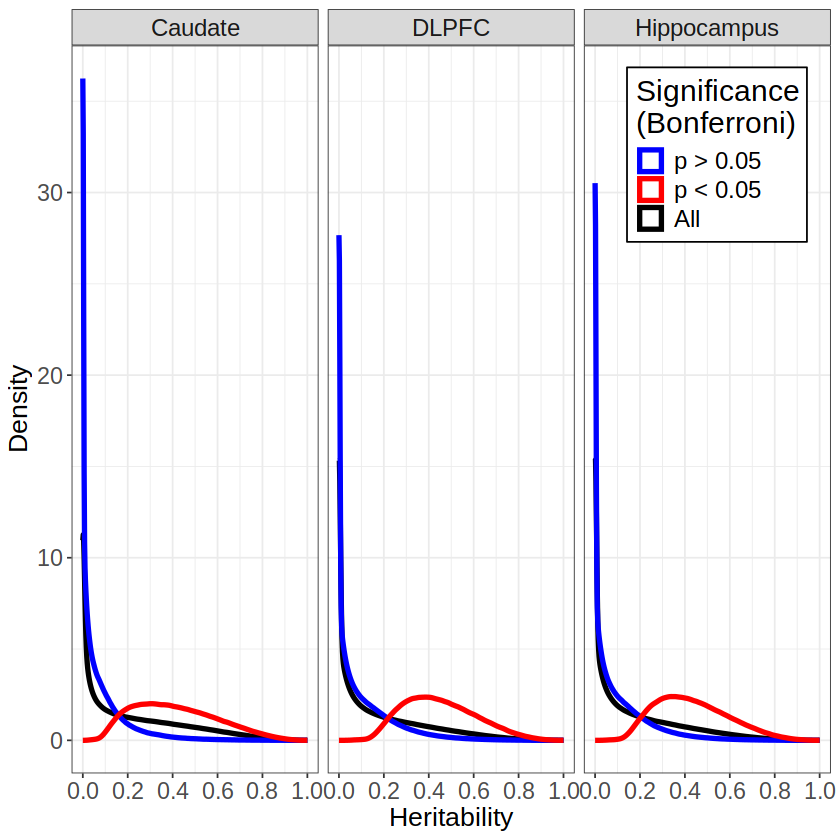

In [60]:
library(data.table)
library(ggplot2)

# Suppose your main data.table is called `heritability` and you have:
# V_G_Vp_caud, Pval_caud, signif_caud
# V_G_Vp_dlpfc, Pval_dlpfc, signif_dlpfc
# V_G_Vp_hippo, Pval_hippo, signif_hippo

# 1) Reshape your data into a "long" format.
df_caud <- heritability[, .(
  region       = "caud",
  heritability = V_G_Vp_caud,
  signif       = signif_caud
)]
df_dlpfc <- heritability[, .(
  region       = "dlpfc",
  heritability = V_G_Vp_dlpfc,
  signif       = signif_dlpfc
)]
df_hippo <- heritability[, .(
  region       = "hippo",
  heritability = V_G_Vp_hippo,
  signif       = signif_hippo
)]
df_long <- rbind(df_caud, df_dlpfc, df_hippo)

# Convert 'signif' to character so we can add an extra category
df_long[, signif := as.character(signif)]

# Create a copy of the data with all rows, labeled as "All"
df_all <- copy(df_long)
df_all[, signif := "All"]

# Combine the two datasets so that each region now has density curves for 
# "p < 0.05", "p > 0.05", and "All"
df_combined <- rbind(df_long, df_all)

# Create a labeller to rename the regions
region_labels <- c("caud"   = "Caudate",
                   "dlpfc"  = "DLPFC",
                   "hippo"  = "Hippocampus")

# 2) Create the plot with shared y-axes, custom legend title (with line break),
#    a black border around the legend, and capitalized "Density" on the y-axis.
p1 <- ggplot(df_combined, aes(x = heritability, color = signif)) +
  geom_density(na.rm = TRUE, size = 1.5) +
  facet_wrap(~ region, ncol = 3, scales = "fixed", labeller = as_labeller(region_labels)) +
  scale_color_manual(
    breaks = c("FALSE", "TRUE", "All"),
    labels = c("p > 0.05", "p < 0.05", "All"),
    values = c("FALSE" = "blue", "TRUE" = "red", "All" = "black")
  ) +
  scale_x_continuous(breaks = c(0.0, 0.2, 0.4, 0.6, 0.8, 1.0)) +
  theme_bw() +
  theme(
    text             = element_text(size = 18),
    axis.title       = element_text(size = 16),
    axis.text        = element_text(size = 14),
    legend.position  = c(0.85, 0.85),  # Moves the legend inside the plot area
    legend.background = element_rect(fill = "white", color = "black")
  ) +
  labs(x = "Heritability", y = "Density", color = "Significance\n(Bonferroni)")

# Display the plot in Jupyter
print(p1)

# 3) Create directories if they don't exist and save the plot
if(!dir.exists("polish_plots/plot_outputs")){
  dir.create("polish_plots/plot_outputs", recursive = TRUE)
}

ggsave(filename = "polish_plots/plot_outputs/oldstyle-Fig1A.png",
       plot     = p1,
       width    = 10,
       height   = 6,
       dpi      = 300)

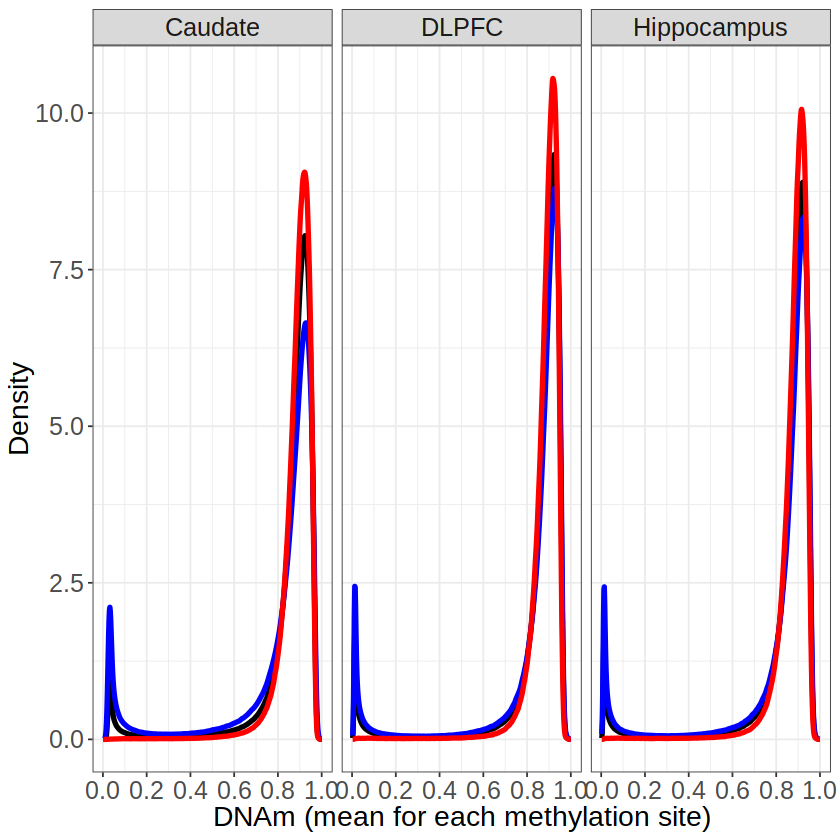

In [62]:
library(data.table)
library(ggplot2)

# Suppose your main data.table is called `heritability` and you have:
# V_G_Vp_caud, Pval_caud, signif_caud
# V_G_Vp_dlpfc, Pval_dlpfc, signif_dlpfc
# V_G_Vp_hippo, Pval_hippo, signif_hippo

# 1) Reshape your data into a "long" format.
df_caud <- heritability[, .(
  region       = "caud",
  DNAm = all_caud_Mean_DNAm_Level,
  signif       = signif_caud
)]
df_dlpfc <- heritability[, .(
  region       = "dlpfc",
  DNAm = all_dlpfc_Mean_DNAm_Level,
  signif       = signif_dlpfc
)]
df_hippo <- heritability[, .(
  region       = "hippo",
  DNAm = all_hippo_Mean_DNAm_Level,
  signif       = signif_hippo
)]
df_long <- rbind(df_caud, df_dlpfc, df_hippo)

# Convert 'signif' to character so we can add an extra category
df_long[, signif := as.character(signif)]

# Create a copy of the data with all rows, labeled as "All"
df_all <- copy(df_long)
df_all[, signif := "All"]

# Combine the two datasets so that each region now has density curves for 
# "p < 0.05", "p > 0.05", and "All"
df_combined <- rbind(df_long, df_all)

# Create a labeller to rename the regions
region_labels <- c("caud"   = "Caudate",
                   "dlpfc"  = "DLPFC",
                   "hippo"  = "Hippocampus")

# 2) Create the plot with shared y-axes, custom legend title (with line break),
#    a black border around the legend, and capitalized "Density" on the y-axis.
df_combined <- df_combined[!is.na(signif)]
p2 <- ggplot(df_combined, aes(x = DNAm, color = signif)) +
  geom_density(na.rm = TRUE, size = 1.5) +
  facet_wrap(~ region, ncol = 3, scales = "fixed", labeller = as_labeller(region_labels)) +
  scale_color_manual(
    breaks = c("FALSE", "TRUE", "All"),
    labels = c("p > 0.05", "p < 0.05", "All"),
    values = c("FALSE" = "blue", "TRUE" = "red", "All" = "black")
  ) +
  scale_x_continuous(breaks = c(0.0, 0.2, 0.4, 0.6, 0.8, 1.0)) +
  theme_bw() +
  theme(
    text             = element_text(size = 19),
    axis.title       = element_text(size = 17),
    axis.text        = element_text(size = 15),
    legend.position  = "none"  # Moves the legend inside the nothing
    #legend.background = element_rect(fill = "white", color = "black")
  ) +
  labs(x = "DNAm (mean for each methylation site)", y = "Density", color = "Significance\n(Bonferroni)")

# Display the plot in Jupyter
print(p2)

# 3) Create directories if they don't exist and save the plot
if(!dir.exists("polish_plots/plot_outputs")){
  dir.create("polish_plots/plot_outputs", recursive = TRUE)
}

ggsave(filename = "polish_plots/plot_outputs/oldstyle-Fig1B.png",
       plot     = p2,
       width    = 10,
       height   = 6,
       dpi      = 300)

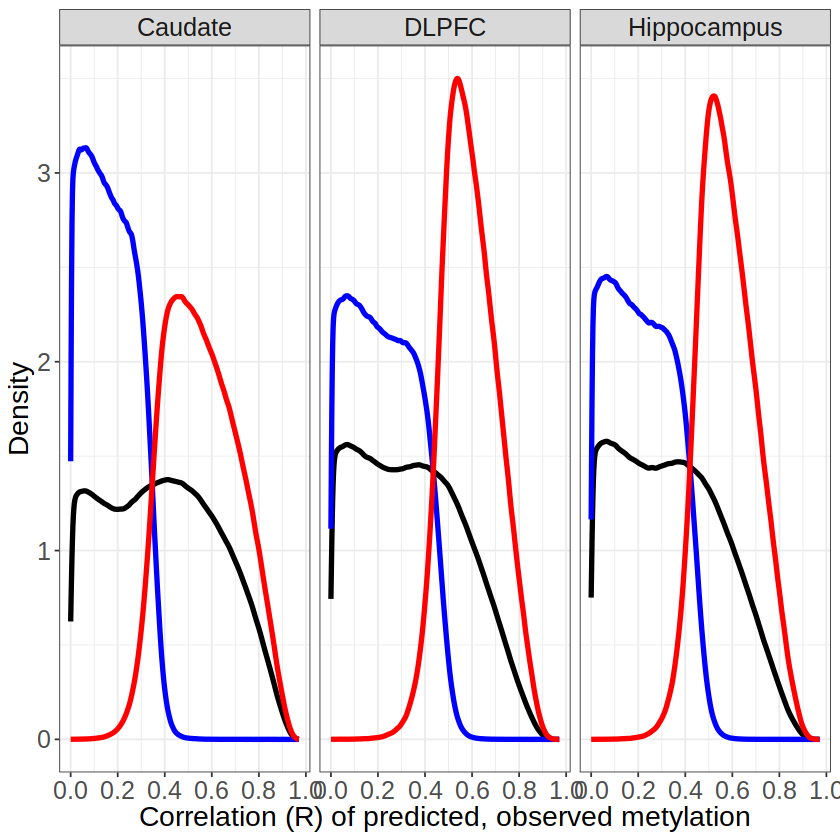

In [63]:
library(data.table)
library(ggplot2)

# Suppose your main data.table is called `heritability` and you have:
# V_G_Vp_caud, Pval_caud, signif_caud
# V_G_Vp_dlpfc, Pval_dlpfc, signif_dlpfc
# V_G_Vp_hippo, Pval_hippo, signif_hippo

# 1) Reshape your data into a "long" format.
df_caud <- heritability[, .(
  region       = "caud",
  cor = all_caud_cor,
  signif       = signif_caud
)]
df_dlpfc <- heritability[, .(
  region       = "dlpfc",
  cor = all_dlpfc_cor,
  signif       = signif_dlpfc
)]
df_hippo <- heritability[, .(
  region       = "hippo",
  cor = all_hippo_cor,
  signif       = signif_hippo
)]
df_long <- rbind(df_caud, df_dlpfc, df_hippo)

# Convert 'signif' to character so we can add an extra category
df_long[, signif := as.character(signif)]

# Create a copy of the data with all rows, labeled as "All"
df_all <- copy(df_long)
df_all[, signif := "All"]

# Combine the two datasets so that each region now has density curves for 
# "p < 0.05", "p > 0.05", and "All"
df_combined <- rbind(df_long, df_all)

# Create a labeller to rename the regions
region_labels <- c("caud"   = "Caudate",
                   "dlpfc"  = "DLPFC",
                   "hippo"  = "Hippocampus")

# 2) Create the plot with shared y-axes, custom legend title (with line break),
#    a black border around the legend, and capitalized "Density" on the y-axis.
df_combined <- df_combined[!is.na(signif)]

p4 <- ggplot(df_combined, aes(x = cor, color = signif)) +
  geom_density(na.rm = TRUE, size = 1.5) +
  facet_wrap(~ region, ncol = 3, scales = "fixed", labeller = as_labeller(region_labels)) +
  scale_color_manual(
    breaks = c("FALSE", "TRUE", "All"),
    labels = c("p > 0.05", "p < 0.05", "All"),
    values = c("FALSE" = "blue", "TRUE" = "red", "All" = "black")
  ) +
  scale_x_continuous(breaks = c(0.0, 0.2, 0.4, 0.6, 0.8, 1.0)) +
  theme_bw() +
  theme(
    text             = element_text(size = 19),
    axis.title       = element_text(size = 17),
    axis.text        = element_text(size = 15),
    legend.position  = "none") +
  labs(x = "Correlation (R) of predicted, observed metylation", y = "Density", color = "Significance\n(Bonferroni)")

# Display the plot in Jupyter
print(p4)

# 3) Create directories if they don't exist and save the plot
if(!dir.exists("polish_plots/plot_outputs")){
  dir.create("polish_plots/plot_outputs", recursive = TRUE)
}

ggsave(filename = "polish_plots/plot_outputs/oldstyle-Fig1C2.png",
       plot     = p4,
       width    = 10,
       height   = 6,
       dpi      = 300)

In [ ]:
library(data.table)
library(ggplot2)

# Define the breaks and labels for bins (0-0.1, 0.1-0.2, …, 0.9-1.0)
breaks <- seq(0, 1, by = 0.1)
bin_labels <- paste0(head(breaks, -1), "-", tail(breaks, -1))

# ==========
# For methylation-based plots:
# We assume DNAm values (mean and variance) are available for each region.
# ==========
df_caud <- heritability[, .(
  region    = "Caudate",
  DNAm_mean = all_caud_Mean_DNAm_Level,
  DNAm_var  = all_caud_Var_DNAm_Level
)]
df_dlpfc <- heritability[, .(
  region    = "DLPFC",
  DNAm_mean = all_dlpfc_Mean_DNAm_Level,
  DNAm_var  = all_dlpfc_Var_DNAm_Level
)]
df_hippo <- heritability[, .(
  region    = "Hippocampus",
  DNAm_mean = all_hippo_Mean_DNAm_Level,
  DNAm_var  = all_hippo_Var_DNAm_Level
)]
df_methyl <- rbind(df_caud, df_dlpfc, df_hippo)

# Define bins based on the mean DNAm (adjust if needed)
df_methyl[, methyl_bin := cut(DNAm_mean, breaks = breaks, labels = bin_labels, include.lowest = TRUE)]

In [68]:
head(heritability)

chr,cg,V_G_Vp_caud,SE_V_G_Vp_caud,Pval_caud,n_caud,V_G_Vp_dlpfc,SE_V_G_Vp_dlpfc,Pval_dlpfc,n_dlpfc,⋯,EA_dlpfc_cor,EA_dlpfc_Mean_DNAm_Level,EA_dlpfc_Var_DNAm_Level,EA_hippo_cor,EA_hippo_Mean_DNAm_Level,EA_hippo_Var_DNAm_Level,chr_cg,signif_caud,signif_dlpfc,signif_hippo
<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<lgl>
1,1069484,1e-06,0.007995,0.5,297,2e-06,0.089671,0.5,163,⋯,NA,NA,NA,NA,NA,NA,1_1069484,FALSE,FALSE,FALSE
1,1069506,1e-06,0.008337,0.5,297,1e-06,0.268270,0.5,163,⋯,NA,NA,NA,NA,NA,NA,1_1069506,FALSE,FALSE,NA
1,1069516,1e-06,0.008550,0.5,297,1e-06,0.397643,0.5,163,⋯,NA,NA,NA,NA,NA,NA,1_1069516,FALSE,FALSE,NA
1,1069530,1e-06,0.008925,0.5,297,1e-06,0.256867,0.5,163,⋯,NA,NA,NA,NA,NA,NA,1_1069530,FALSE,FALSE,FALSE
1,1069533,NA,NA,NA,NA,4e-06,0.109714,0.5,163,⋯,NA,NA,NA,NA,NA,NA,1_1069533,NA,FALSE,FALSE
1,1069539,1e-06,0.009226,0.5,297,3e-06,0.101349,0.5,163,⋯,NA,NA,NA,NA,NA,NA,1_1069539,FALSE,FALSE,FALSE


In [80]:
head(heritability[, 1:20])

chr,cg,V_G_Vp_caud,SE_V_G_Vp_caud,Pval_caud,n_caud,V_G_Vp_dlpfc,SE_V_G_Vp_dlpfc,Pval_dlpfc,n_dlpfc,V_G_Vp_hippo,SE_V_G_Vp_hippo,Pval_hippo,n_hippo,AA_caud_cor,AA_caud_Mean_DNAm_Level,AA_caud_Var_DNAm_Level,AA_dlpfc_cor,AA_dlpfc_Mean_DNAm_Level,AA_dlpfc_Var_DNAm_Level
<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1069484,1e-06,0.007995,0.5,297,2e-06,0.089671,0.5,163,1e-06,0.012782,0.5,178,NA,NA,NA,NA,NA,NA
1,1069506,1e-06,0.008337,0.5,297,1e-06,0.268270,0.5,163,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,1069516,1e-06,0.008550,0.5,297,1e-06,0.397643,0.5,163,NA,NA,NA,NA,0.0218494,0.08227722,0.0004890334,0.006469764,0.06367978,0.0001481000
1,1069530,1e-06,0.008925,0.5,297,1e-06,0.256867,0.5,163,1e-06,0.015847,0.5,178,0.1076025,0.08916471,0.0005390645,NA,NA,NA
1,1069533,NA,NA,NA,NA,4e-06,0.109714,0.5,163,1e-06,0.016125,0.5,178,NA,NA,NA,0.013839175,0.07210926,0.0001776037
1,1069539,1e-06,0.009226,0.5,297,3e-06,0.101349,0.5,163,1e-06,0.016722,0.5,178,NA,NA,NA,0.149757215,0.07537436,0.0001893771


In [83]:
table(heritability[!is.na(AA_caud_Mean_DNAm_Level)]$chr)


      1       2       3       4       5       6       7       8       9      10 
1302789 1397980 1079202 1021814  989746  964490  975824  839174  683346  870945 
     11      12      13      14      15      16      17      18      19      20 
 797825  806022  544000  546522  519054  586841  623981  464435  549320  446370 
     21      22 
 233359  319435 

In [69]:
head(df_caud)

region,DNAm_mean,DNAm_var
<chr>,<dbl>,<dbl>
Caudate,0.07002377,0.0007280639
Caudate,NA,NA
Caudate,0.08341811,0.0008662243
Caudate,NA,NA
Caudate,0.09186327,0.0009479719
Caudate,0.09508891,0.0009781951


In [70]:
dim(df_caud)

[1] 24120151        3

In [71]:
head(df_hippo)

region,DNAm_mean,DNAm_var
<chr>,<dbl>,<dbl>
Hippocampus,0.04896367,0.0001406751
Hippocampus,0.05703232,0.0001730697
Hippocampus,NA,NA
Hippocampus,NA,NA
Hippocampus,NA,NA
Hippocampus,NA,NA


In [72]:
dim(df_hippo)

[1] 24120151        3

In [78]:
dim(na.omit(df_hippo))

[1] 15177099        3

In [73]:
head(df_dlpfc)

region,DNAm_mean,DNAm_var
<chr>,<dbl>,<dbl>
DLPFC,NA,NA
DLPFC,NA,NA
DLPFC,NA,NA
DLPFC,NA,NA
DLPFC,NA,NA
DLPFC,NA,NA


In [74]:
dim(na.omit(df_dlpfc))

[1] 14980307        3

In [65]:
head(df_methyl)

region,DNAm_mean,DNAm_var,methyl_bin
<chr>,<dbl>,<dbl>,<fct>
Caudate,0.07002377,0.0007280639,0-0.1
Caudate,NA,NA,NA
Caudate,0.08341811,0.0008662243,0-0.1
Caudate,NA,NA,NA
Caudate,0.09186327,0.0009479719,0-0.1
Caudate,0.09508891,0.0009781951,0-0.1


In [66]:
dim(df_methyl)

[1] 72360453        4

In [67]:
dim(na.omit(df_methyl))

[1] 47666046        4

In [ ]:
p_methyl_mean_box <- ggplot(df_methyl, aes(x = methyl_bin, y = DNAm_mean)) +
  geom_boxplot() +
  facet_wrap(~ region) +
  labs(x = "Methylation Bin", y = "Mean DNAm") +
  theme_bw()

# Plot 2: Boxplot of Variance DNAm by methylation bins
p_methyl_var_box <- ggplot(df_methyl, aes(x = methyl_bin, y = DNAm_var)) +
  geom_boxplot() +
  facet_wrap(~ region) +
  labs(x = "Methylation Bin", y = "Variance DNAm") +
  theme_bw()

In [ ]:
# (Optionally, to create violin plots, simply replace geom_boxplot() with geom_violin())

# ==========
# For correlation-based plots:
# We assume each region has a correlation column (e.g. all_caud_cor) along with DNAm stats.
# ==========
df_caud_cor <- heritability[, .(
  region    = "Caudate",
  DNAm_mean = all_caud_Mean_DNAm_Level,
  DNAm_var  = all_caud_Var_DNAm_Level,
  cor       = all_caud_cor
)]
df_dlpfc_cor <- heritability[, .(
  region    = "DLPFC",
  DNAm_mean = all_dlpfc_Mean_DNAm_Level,
  DNAm_var  = all_dlpfc_Var_DNAm_Level,
  cor       = all_dlpfc_cor
)]
df_hippo_cor <- heritability[, .(
  region    = "Hippocampus",
  DNAm_mean = all_hippo_Mean_DNAm_Level,
  DNAm_var  = all_hippo_Var_DNAm_Level,
  cor       = all_hippo_cor
)]
df_cor <- rbind(df_caud_cor, df_dlpfc_cor, df_hippo_cor)

# Define bins for correlation values
df_cor[, cor_bin := cut(cor, breaks = breaks, labels = bin_labels, include.lowest = TRUE)]

# Plot 3: Boxplot of Mean DNAm by correlation bins
p_cor_mean_box <- ggplot(df_cor, aes(x = cor_bin, y = DNAm_mean)) +
  geom_boxplot() +
  facet_wrap(~ region) +
  labs(x = "Correlation Bin", y = "Mean DNAm") +
  theme_bw()

# Plot 4: Boxplot of Variance DNAm by correlation bins
p_cor_var_box <- ggplot(df_cor, aes(x = cor_bin, y = DNAm_var)) +
  geom_boxplot() +
  facet_wrap(~ region) +
  labs(x = "Correlation Bin", y = "Variance DNAm") +
  theme_bw()

# Display the plots in your R session (or Jupyter notebook)
print(p_methyl_mean_box)
print(p_methyl_var_box)
print(p_cor_mean_box)
print(p_cor_var_box)

# Save plots if needed (adjust file paths accordingly)
if(!dir.exists("polish_plots/plot_outputs")){
  dir.create("polish_plots/plot_outputs", recursive = TRUE)
}

ggsave(filename = "polish_plots/plot_outputs/methyl_mean_box.png", plot = p_methyl_mean_box, width = 10, height = 6, dpi = 300)
ggsave(filename = "polish_plots/plot_outputs/methyl_var_box.png",  plot = p_methyl_var_box,  width = 10, height = 6, dpi = 300)
ggsave(filename = "polish_plots/plot_outputs/cor_mean_box.png",    plot = p_cor_mean_box,    width = 10, height = 6, dpi = 300)
ggsave(filename = "polish_plots/plot_outputs/cor_var_box.png",     plot = p_cor_var_box,     width = 10, height = 6, dpi = 300)

Warning message:
“Removed 24694407 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


In [ ]:
library(data.table)
library(ggplot2)

# Suppose your main data.table is called `heritability` and you have:
# all_caud_Var_DNAm_Level, signif_caud
# all_dlpfc_Var_DNAm_Level, signif_dlpfc
# all_hippo_Var_DNAm_Level, signif_hippo

# 1) Reshape your data into a "long" format.
df_caud <- heritability[, .(
  region  = "caud",
  DNAm    = all_caud_Mean_DNAm_Level,
  signif  = signif_caud
)]
df_dlpfc <- heritability[, .(
  region  = "dlpfc",
  DNAm    = all_dlpfc_Mean_DNAm_Level,
  signif  = signif_dlpfc
)]
df_hippo <- heritability[, .(
  region  = "hippo",
  DNAm    = all_hippo_Mean_DNAm_Level,
  signif  = signif_hippo
)]
df_long <- rbind(df_caud, df_dlpfc, df_hippo)

# Convert 'signif' to character so we can add an extra category
df_long[, signif := as.character(signif)]
df_long <- df_long[!is.na(signif), ]

# Create a copy of the data with all rows, labeled as "All"
#df_all <- copy(df_long)
#df_all[, signif := "All"]

# Combine the two datasets so that each region now has data for:
# "p < 0.05", "p > 0.05", and "All"
df_combined <- df_long

# Create a labeller to rename the regions
region_labels <- c("caud"  = "Caudate",
                   "dlpfc" = "DLPFC",
                   "hippo" = "Hippocampus")

# 2) Create the violin plot with box plot overlay.
#    Here, the x-axis is the significance category and the y-axis is the DNAm variance.
df_combined <- df_combined[!is.na(signif)]
p5 <- ggplot(df_combined, aes(x = signif, y = DNAm, fill = signif)) +
  geom_violin(na.rm = TRUE, alpha = 0.5) +
  geom_boxplot(width = 0.1, outlier.shape = NA, na.rm = TRUE) +
  facet_wrap(~ region, ncol = 3, scales = "fixed", labeller = as_labeller(region_labels)) +
  scale_fill_manual(
    breaks = c("FALSE", "TRUE", "All"),
    labels = c("p > 0.05", "p < 0.05", "All"),
    values = c("FALSE" = "blue", "TRUE" = "red", "All" = "black")
  ) +
  scale_x_discrete(labels = c("FALSE" = "p > 0.05", "TRUE" = "p < 0.05", "All" = "All")) +
  theme_bw() +
  theme(
    text             = element_text(size = 19),
    axis.title       = element_text(size = 17),
    axis.text        = element_text(size = 15),
    legend.position  = "none",  # Moves the legend inside the plot area
    legend.background = element_rect(fill = "white", color = "black")
  ) +
  labs(x = "DNAm (mean for each methylation site)",
              y = "DNAm variance (across samples for each methylation site)",
       fill = "Significance\n(Bonferroni)")

# Display the plot in Jupyter
print(p5)

# 3) Create directories if they don't exist and save the plot
if(!dir.exists("polish_plots/plot_outputs")){
  dir.create("polish_plots/plot_outputs", recursive = TRUE)
}

ggsave(filename = "polish_plots/plot_outputs/Fig1D-var-violin.png",
       plot     = p5,
       width    = 10,
       height   = 6,
       dpi      = 300)

In [ ]:
ggsave("polish_plots/plot_outputs/FigS1-ggpairs")

In [ ]:
# Load required packages
library(data.table)
library(GGally)
library(ggplot2)

# Create a new data.table with the nine variables and rename columns for clarity
df_pairs <- heritability[, .(
  Caudate_herit     = V_G_Vp_caud,
  DLPFC_herit       = V_G_Vp_dlpfc,
  Hippocampus_herit = V_G_Vp_hippo,
  
  Caudate_DNAm      = all_caud_Mean_DNAm_Level,
  DLPFC_DNAm        = all_dlpfc_Mean_DNAm_Level,
  Hippocampus_DNAm  = all_hippo_Mean_DNAm_Level,
  
  Caudate_cor       = cor_caud,   # Ensure these column names match your dataset
  DLPFC_cor         = cor_dlpfc,
  Hippocampus_cor   = cor_hippo
)]

# Create the GGally ggpairs plot with customizations:
# - Upper panels: display correlation coefficients (with a custom text size)
# - Lower panels: display scatter plots with a smooth trend (semi-transparent)
# - Diagonal: display density plots
p_pairs <- ggpairs(
  df_pairs,
  upper = list(continuous = wrap("cor", size = 4)),
  lower = list(continuous = wrap("smooth", alpha = 0.3, size = 0.1)),
  diag  = list(continuous = wrap("densityDiag", alpha = 0.5))
) +
  theme_bw() +
  theme(text = element_text(size = 14))

# Display the plot
print(p_pairs)

## save out merged_data

## bring in the GWAS data

In [ ]:
fwrite(heritability, "polish_plots/50-OUT_merged_h2_cor_more.csv")

## Merge both DNAm, cor and heritability (but not yet all with intersected BED data)

### first we do it for files containing DNAm and R^2 (cor)

In [35]:
#dnAm_combined <-  fread("50-OUT/50-INTERMEDIATE_step10_dnAm_combined.csv")

# Load the intersected BED into R
intersect_dt <- tryCatch({
  fread(intersect_output, header = FALSE, sep = "\t",
        col.names = c("Unique_Chromosome", "Unique_Start", "Unique_End",
                      "Feature_Chromosome", "Feature_Start", "Feature_End", "Feature_INFO"))
}, error = function(e){
  stop(paste("Failed to read intersect output BED file:", intersect_output, "\nError:", e$message))
})


In [37]:
# ===============================
# 11. Merge DNA Methylation Data with Intersected BED Data
# ===============================
log_message("Merging DNA methylation data with intersected BED data.")

intersect_dt[, cg := as.integer(Unique_End)]

intersect_dt[, chr := as.integer(gsub("chr", "", Unique_Chromosome))]

# Merge with DNA methylation data
merged_data <- merge(intersect_dt, dnAm_combined, by = c("chr", "cg"), all = TRUE)

# Print the first few rows
log_message("First 10 rows of merged data:")
print(head(merged_data, 10))

log_message("Completed merging DNA methylation data.\n")

[2024-12-02 15:03:29] Merging DNA methylation data with intersected BED data.
[2024-12-02 15:26:18] First 10 rows of merged data:
Key: <chr, cg>
      chr      cg Unique_Chromosome Unique_Start Unique_End Feature_Chromosome
    <int>   <int>            <char>        <int>      <int>             <char>
 1:     1 1069484              chr1      1069483    1069484               chr1
 2:     1 1069484              chr1      1069483    1069484               chr1
 3:     1 1069484              chr1      1069483    1069484               chr1
 4:     1 1069484              chr1      1069483    1069484               chr1
 5:     1 1069506              <NA>           NA         NA               <NA>
 6:     1 1069516              chr1      1069515    1069516               chr1
 7:     1 1069516              chr1      1069515    1069516               chr1
 8:     1 1069516              chr1      1069515    1069516               chr1
 9:     1 1069516              chr1      1069515    1069516      

In [39]:
fwrite(merged_data, "50-OUT/50-INTERMEDIATE_DNAm_cor_features_combined_pre-heritability.csv")

In [40]:
start_col <- 10
columns_to_round <- start_col:ncol(merged_data)

In [41]:
# Apply rounding in place
merged_data[, (columns_to_round) := lapply(.SD, round, digits = 6), .SDcols = columns_to_round]

# Write the modified data back to disk
fwrite(merged_data, "50-OUT/50-INTERMEDIATE_DNAm_cor_features_combined_pre-heritability-6digits.csv")

### Now we do it for files with heritability

In [42]:
intersect_dt <- NULL
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,27297259,1457.9,50400497,2691.7,27845438,1487.2
Vcells,15377422383,117320.5,33933359630,258891.0,33933264406,258890.3


In [ ]:
merged_data <- merge(merged_data, final_wide_heritability, by = c("chr", "cg"), all = TRUE)

In [ ]:
fwrite(merged_data, file = "50-OUT/50-OUT_final_merged_DNAm_data.csv", sep = ",", quote = FALSE)

Plots we want:
Figure 1.
1A- cor across methylation levels
1B- heritability across methylation levels
1C- cor and heritability relationship

In [ ]:
Figure 2

In [ ]:
dim(intersect_dt)

In [ ]:
head(dnAm_combined)

In [ ]:
head(intersect_dt)

In [ ]:
dim(merged_data)

In [ ]:
# ===============================
# Final Outputs and Cleanup
# ===============================
log_message("\n==========================================\n")
log_message("Workflow Completed Successfully.")
log_message("==========================================\n")

# Optionally, save the merged data to a file
if(!is.null(merged_data)){
  final_output_csv <- "50-OUT/final_merged_DNAm_data.csv"  # Update if necessary
  tryCatch({
    fwrite(merged_data, file = final_output_csv, sep = ",", quote = FALSE)
    log_message(paste("Final merged data saved to", final_output_csv))
  }, error = function(e){
    stop(paste("Failed to write final merged data.\nError:", e$message))
  })
} else {
  log_message("No merged data to save.")
}

# End of Script

colnames(intersect_dt)

head(intersect_dt)

library(stringr)

library(stringr)
library(data.table)
#merged_data <- fread("final_merged_DNAm_data.csv")
dim(merged_data)

In [ ]:
head(merged_data$Feature_INFO)

In [ ]:
is.data.table(merged_data)

In [ ]:
dim(merged_data[!grepl("ttribute", merged_data$Feature_INFO), ])

In [ ]:
merged_data <- merged_data[!grepl("ttribute", merged_data$Feature_INFO), ]
dim(merged_data)

# Ensure the data frame has at least 100,000 rows
if (nrow(merged_data) >= 1000000) {
  set.seed(123)  # Set seed for reproducibility
  merged_data <- merged_data[sample(nrow(merged_data), 1000000), ]
} else {
  stop("The data frame has fewer than 100,000 rows.")
}


merged_data$feature_type <- str_split_fixed(merged_data$Feature_INFO, "\\|", 2)[,1]

head(str_split_fixed(merged_data$Feature_INFO, "\\|", 2))

#merged_data_backup_w_attributes <- merged_data

In [ ]:
################################################################################ 
# Part A: Analysis of CpG Overlaps with Genomic Features Across R² and DNAm Level Bins
# This script analyzes the proportion of CpG sites overlapping with various
# genomic features across different bins of predictive power (R²) and mean DNAm levels.
# It generates comprehensive plots and stacks them using gridExtra for each feature type.
################################################################################

# Load necessary libraries
library(data.table)
library(ggplot2)
library(scales)
library(stringr)
library(gtools)
library(RColorBrewer)
library(gridExtra)

# Initialize timestamp function for logging
timestamp <- function() format(Sys.time(), "%Y-%m-%d %H:%M:%S")

# Ensure 'merged_data' is loaded
if (!exists("merged_data")) {
    stop("Error: 'merged_data' is not loaded. Please load your merged data into 'merged_data' before running the script.")
}

# Check if 'feature_type' column exists
if (!"feature_type" %in% names(merged_data)) {
    stop("Error: 'feature_type' column is missing from 'merged_data'. Please check your data preprocessing steps.")
}

# Ensure 'feature_type' is character
merged_data[, feature_type := as.character(feature_type)]

# Create R_squared_bin based on 'all_caud_cor'
cat(timestamp(), "- Binning R² values into deciles...\n")
merged_data[, R_squared_bin := cut(all_caud_cor, breaks = seq(0, 1, by = 0.1), include.lowest = TRUE)]

# Ensure bins are ordered correctly
merged_data$R_squared_bin <- factor(merged_data$R_squared_bin, levels = mixedsort(unique(merged_data$R_squared_bin)))

# Add "Missing" to the levels and assign
levels(merged_data$R_squared_bin) <- c(levels(merged_data$R_squared_bin), "Missing")
merged_data$R_squared_bin[is.na(merged_data$R_squared_bin)] <- 'Missing'

# Create DNAm_Level_bin based on 'all_caud_Mean_DNAm_Level'
cat(timestamp(), "- Binning DNAm levels into deciles...\n")
# Determine the range and breaks
dnam_min <- min(merged_data$all_caud_Mean_DNAm_Level, na.rm = TRUE)
dnam_max <- max(merged_data$all_caud_Mean_DNAm_Level, na.rm = TRUE)
merged_data[, DNAm_Level_bin := cut(all_caud_Mean_DNAm_Level, breaks = seq(dnam_min, dnam_max, length.out = 11), include.lowest = TRUE)]

# Ensure bins are ordered correctly
merged_data$DNAm_Level_bin <- factor(merged_data$DNAm_Level_bin, levels = mixedsort(unique(merged_data$DNAm_Level_bin)))

# Add "Missing" to the levels and assign
levels(merged_data$DNAm_Level_bin) <- c(levels(merged_data$DNAm_Level_bin), "Missing")
merged_data$DNAm_Level_bin[is.na(merged_data$DNAm_Level_bin)] <- 'Missing'

# Function to sanitize feature names for file names
sanitize_filename <- function(filename) {
    gsub("[/\\?%*:|\"<> ]", "_", filename)
}

# Function to get human-readable feature name
get_human_readable_feature_name <- function(feature) {
    # Handle features, e.g., split by '_'
    feature <- gsub("_", " ", feature)
    # Remove any prefixes like 'E071_15_coreMarks_mnemonics|feature:'
    feature <- sub("E[0-9]+_[0-9]+_coreMarks_mnemonics\\|feature:", "", feature)
    return(feature)
}

# Create datasets for different analyses
# A. Unique CpG Data
unique_cpg_data <- merged_data[, .(
    all_caud_cor = unique(all_caud_cor)[1],
    R_squared_bin = unique(R_squared_bin)[1],
    all_caud_Mean_DNAm_Level = unique(all_caud_Mean_DNAm_Level)[1],
    DNAm_Level_bin = unique(DNAm_Level_bin)[1]
), by = cg]

# B. Feature-Specific Data
feature_specific_data <- merged_data

# Set up the output directory
output_dir <- "50-OUT"
if (!dir.exists(output_dir)) {
    dir.create(output_dir)
}

# ============================
# A. Unique CpG Analyses
# ============================

cat(timestamp(), "- Performing analyses on unique CpG data...\n")

# Perform statistical tests for unique CpG data
# Example: Correlation between R_squared_bin and DNAm_Level_bin

# Ensure that bins are ordered factors
unique_cpg_data$R_squared_bin <- factor(unique_cpg_data$R_squared_bin, levels = levels(merged_data$R_squared_bin))
unique_cpg_data$DNAm_Level_bin <- factor(unique_cpg_data$DNAm_Level_bin, levels = levels(merged_data$DNAm_Level_bin))

# Perform a Chi-squared test between R_squared_bin and DNAm_Level_bin
contingency_table_unique <- table(unique_cpg_data$R_squared_bin, unique_cpg_data$DNAm_Level_bin)

# Check expected counts
expected_counts_unique <- chisq.test(contingency_table_unique)$expected

if (any(expected_counts_unique < 5)) {
    # Use Fisher's Exact Test if expected counts are low
    fisher_test_unique <- fisher.test(contingency_table_unique)
    test_used_unique <- "Fisher's Exact Test"
    p_value_unique <- fisher_test_unique$p.value
} else {
    # Use Chi-squared Test
    chi_squared_test_unique <- chisq.test(contingency_table_unique)
    test_used_unique <- "Chi-squared Test"
    p_value_unique <- chi_squared_test_unique$p.value
}

# Output the test results
cat("Statistical Test for Unique CpG Data:\n")
cat("Test Used:", test_used_unique, "\n")
cat("P-value:", signif(p_value_unique, 3), "\n")

# ============================
# B. Feature-Specific Analyses
# ============================

# Initialize list to store statistical results
statistical_results <- list()

# Get list of unique features
unique_features <- unique(merged_data$feature_type)
unique_features <- unique_features[!is.na(unique_features)]

# Loop through each feature to generate plots and perform statistical analysis
for (feature in unique_features) {
    col_name <- sanitize_filename(feature)
    feature_hr <- get_human_readable_feature_name(feature)
    
    cat(timestamp(), "- Processing feature:", feature_hr, "\n")
    
    # Subset data for the current feature
    feature_data <- feature_specific_data[feature_type == feature]
    
    # Calculate number of overlapping CpGs per R² bin within the feature
    overlap_counts_r2 <- feature_data[, .N, by = R_squared_bin]
    setnames(overlap_counts_r2, "N", "Overlapping_CpGs")
    
    # Calculate total CpGs per R² bin from the entire dataset
    total_counts_r2 <- merged_data[, .N, by = R_squared_bin]
    setnames(total_counts_r2, "N", "Total_CpGs")
    
    # Merge to get total counts for R² bins
    overlap_counts_r2_full <- merge(overlap_counts_r2, total_counts_r2, by = "R_squared_bin", all.x = TRUE)
    
    # Replace NA in Overlapping_CpGs with 0
    overlap_counts_r2_full[is.na(Overlapping_CpGs), Overlapping_CpGs := 0]
    
    # Calculate proportion for R² bins
    overlap_counts_r2_full[, Proportion := Overlapping_CpGs / Total_CpGs]
    
    # Generate the plot for R² bins
    p_r2 <- ggplot(overlap_counts_r2_full, aes(x = R_squared_bin, y = Proportion)) +
        geom_bar(stat = "identity", fill = "steelblue") +
        theme_minimal(base_size = 16) +
        labs(
            title = paste0("Proportion of CpGs Overlapping with ", feature_hr, " Across R² Bins"),
            x = expression(R^2 ~ "Bins"),
            y = "Proportion of CpGs Overlapping"
        ) +
        theme(
            plot.title = element_text(hjust = 0.5, face = "bold"),
            axis.text.x = element_text(angle = 90, vjust = 0.5)
        )
    
    # Calculate number of overlapping CpGs per DNAm Level bin within the feature
    overlap_counts_dnam <- feature_data[, .N, by = DNAm_Level_bin]
    setnames(overlap_counts_dnam, "N", "Overlapping_CpGs")
    
    # Calculate total CpGs per DNAm Level bin from the entire dataset
    total_counts_dnam <- merged_data[, .N, by = DNAm_Level_bin]
    setnames(total_counts_dnam, "N", "Total_CpGs")
    
    # Merge to get total counts for DNAm Level bins
    overlap_counts_dnam_full <- merge(overlap_counts_dnam, total_counts_dnam, by = "DNAm_Level_bin", all.x = TRUE)
    
    # Replace NA in Overlapping_CpGs with 0
    overlap_counts_dnam_full[is.na(Overlapping_CpGs), Overlapping_CpGs := 0]
    
    # Calculate proportion for DNAm Level bins
    overlap_counts_dnam_full[, Proportion := Overlapping_CpGs / Total_CpGs]
    
    # Generate the plot for DNAm Level bins
    p_dnam <- ggplot(overlap_counts_dnam_full, aes(x = DNAm_Level_bin, y = Proportion)) +
        geom_bar(stat = "identity", fill = "darkgreen") +
        theme_minimal(base_size = 16) +
        labs(
            title = paste0("Proportion of CpGs Overlapping with ", feature_hr, " Across DNAm Level Bins"),
            x = "Mean DNAm Level Bins",
            y = "Proportion of CpGs Overlapping"
        ) +
        theme(
            plot.title = element_text(hjust = 0.5, face = "bold"),
            axis.text.x = element_text(angle = 90, vjust = 0.5)
        )
    
    # Stack the two plots using gridExtra
    combined_plot <- grid.arrange(p_r2, p_dnam, ncol = 1)
    
    # Save the combined plot
    plot_file <- file.path(output_dir, paste0("50-OUT_overlap_plot_", col_name, "_combined.png"))
    ggsave(filename = plot_file, plot = combined_plot, width = 12, height = 16, dpi = 300)
    
    cat(timestamp(), "- Combined plot saved to", plot_file, "\n")
    
    # Statistical Analysis for R² bins
    # Create contingency table with overlapping and non-overlapping counts
    contingency_table_r2 <- overlap_counts_r2_full[, .(Overlap = Overlapping_CpGs, Non_Overlap = Total_CpGs - Overlapping_CpGs), by = R_squared_bin]
    contingency_matrix_r2 <- as.matrix(contingency_table_r2[, .(Overlap, Non_Overlap)])
    rownames(contingency_matrix_r2) <- contingency_table_r2$R_squared_bin
    
    # Perform Chi-squared test or Fisher's Exact Test based on expected counts
    if (any(chisq.test(contingency_matrix_r2)$expected < 5)) {
        # Use Fisher's Exact Test
        fisher_test_r2 <- fisher.test(contingency_matrix_r2)
        test_used_r2 <- "Fisher's Exact Test"
        p_value_r2 <- fisher_test_r2$p.value
        cat("Note: Fisher's Exact Test used for feature:", feature_hr, "in R² bins due to low expected counts.\n")
    } else {
        # Use Chi-squared Test
        chi_squared_test_r2 <- chisq.test(contingency_matrix_r2)
        test_used_r2 <- "Chi-squared Test"
        p_value_r2 <- chi_squared_test_r2$p.value
    }
    
    # Statistical Analysis for DNAm Level bins
    # Create contingency table with overlapping and non-overlapping counts
    contingency_table_dnam <- overlap_counts_dnam_full[, .(Overlap = Overlapping_CpGs, Non_Overlap = Total_CpGs - Overlapping_CpGs), by = DNAm_Level_bin]
    contingency_matrix_dnam <- as.matrix(contingency_table_dnam[, .(Overlap, Non_Overlap)])
    rownames(contingency_matrix_dnam) <- contingency_table_dnam$DNAm_Level_bin
    
    # Perform Chi-squared test or Fisher's Exact Test based on expected counts
    if (any(chisq.test(contingency_matrix_dnam)$expected < 5)) {
        # Use Fisher's Exact Test
        fisher_test_dnam <- fisher.test(contingency_matrix_dnam)
        test_used_dnam <- "Fisher's Exact Test"
        p_value_dnam <- fisher_test_dnam$p.value
        cat("Note: Fisher's Exact Test used for feature:", feature_hr, "in DNAm Level bins due to low expected counts.\n")
    } else {
        # Use Chi-squared Test
        chi_squared_test_dnam <- chisq.test(contingency_matrix_dnam)
        test_used_dnam <- "Chi-squared Test"
        p_value_dnam <- chi_squared_test_dnam$p.value
    }
    
    # Collect results
    statistical_results[[feature_hr]] <- list(
        Feature = feature_hr,
        R2_Test = test_used_r2,
        R2_P_value = signif(p_value_r2, 3),
        DNAm_Test = test_used_dnam,
        DNAm_P_value = signif(p_value_dnam, 3)
    )
}

# Convert statistical_results to a data.table
stats_table <- rbindlist(lapply(statistical_results, function(x) as.data.table(x)), fill = TRUE)

# Save statistical results to a CSV file
stats_file <- file.path(output_dir, "50-OUT_statistical_results.csv")
fwrite(stats_table, stats_file)

cat(timestamp(), "- Statistical results saved to", stats_file, "\n")

In [ ]:
################################################################################ 
# Part A: Analysis of CpG Overlaps with Genomic Features Across R² and DNAm Level Bins
# This script analyzes the proportion of CpG sites overlapping with various
# genomic features across different bins of predictive power (R²) and mean DNAm levels.
# It generates horizontal clustered bar plots for all feature types.
################################################################################

# Load necessary libraries
library(data.table)
library(ggplot2)
library(scales)
library(stringr)
library(gtools)
library(RColorBrewer)
library(gridExtra)

# Initialize timestamp function for logging
timestamp <- function() format(Sys.time(), "%Y-%m-%d %H:%M:%S")

# Ensure 'merged_data' is loaded
if (!exists("merged_data")) {
    stop("Error: 'merged_data' is not loaded. Please load your merged data into 'merged_data' before running the script.")
}

# Check if 'feature_type' column exists
if (!"feature_type" %in% names(merged_data)) {
    stop("Error: 'feature_type' column is missing from 'merged_data'. Please check your data preprocessing steps.")
}

# Ensure 'feature_type' is character
merged_data[, feature_type := as.character(feature_type)]

# Create R_squared_bin based on 'all_caud_cor'
cat(timestamp(), "- Binning R² values into deciles...\n")
merged_data[, R_squared_bin := cut(all_caud_cor, breaks = seq(0, 1, by = 0.1), include.lowest = TRUE)]

# Ensure bins are ordered correctly
merged_data$R_squared_bin <- factor(merged_data$R_squared_bin, levels = mixedsort(unique(merged_data$R_squared_bin)))

# Add "Missing" to the levels and assign
levels(merged_data$R_squared_bin) <- c(levels(merged_data$R_squared_bin), "Missing")
merged_data$R_squared_bin[is.na(merged_data$R_squared_bin)] <- 'Missing'

# Create DNAm_Level_bin based on 'all_caud_Mean_DNAm_Level'
cat(timestamp(), "- Binning DNAm levels into deciles...\n")
# Determine the range and breaks
dnam_min <- min(merged_data$all_caud_Mean_DNAm_Level, na.rm = TRUE)
dnam_max <- max(merged_data$all_caud_Mean_DNAm_Level, na.rm = TRUE)
merged_data[, DNAm_Level_bin := cut(all_caud_Mean_DNAm_Level, breaks = seq(dnam_min, dnam_max, length.out = 11), include.lowest = TRUE)]

# Ensure bins are ordered correctly
merged_data$DNAm_Level_bin <- factor(merged_data$DNAm_Level_bin, levels = mixedsort(unique(merged_data$DNAm_Level_bin)))

# Add "Missing" to the levels and assign
levels(merged_data$DNAm_Level_bin) <- c(levels(merged_data$DNAm_Level_bin), "Missing")
merged_data$DNAm_Level_bin[is.na(merged_data$DNAm_Level_bin)] <- 'Missing'

# Function to sanitize feature names for file names
sanitize_filename <- function(filename) {
    gsub("[/\\?%*:|\"<> ]", "_", filename)
}

# Function to get human-readable feature name
get_human_readable_feature_name <- function(feature) {
    # Handle features, e.g., split by '_'
    feature <- gsub("_", " ", feature)
    # Remove any prefixes like 'E071_15_coreMarks_mnemonics|feature:'
    feature <- sub("E[0-9]+_[0-9]+_coreMarks_mnemonics\\|feature:", "", feature)
    return(feature)
}

# Set up the output directory
output_dir <- "50-OUT"
if (!dir.exists(output_dir)) {
    dir.create(output_dir)
}

# Get list of unique features
unique_features <- unique(merged_data$feature_type)
unique_features <- unique_features[!is.na(unique_features)]

# Initialize list to store statistical results
statistical_results <- list()

# ============================
# Data Preparation
# ============================

cat(timestamp(), "- Preparing data for plotting and statistical tests...\n")

# For R² bins
r2_data_list <- list()

for (feature in unique_features) {
    feature_hr <- get_human_readable_feature_name(feature)
    
    # Subset data for the current feature
    feature_data <- merged_data[feature_type == feature]
    
    # Calculate number of overlapping CpGs per R² bin for the feature
    overlap_counts_r2 <- feature_data[, .N, by = R_squared_bin]
    setnames(overlap_counts_r2, "N", "Overlapping_CpGs")
    
    # Total CpGs per R² bin from the entire dataset
    total_counts_r2 <- merged_data[, .N, by = R_squared_bin]
    setnames(total_counts_r2, "N", "Total_CpGs")
    
    # Merge to get total counts for R² bins
    overlap_counts_r2_full <- merge(overlap_counts_r2, total_counts_r2, by = "R_squared_bin", all = TRUE)
    overlap_counts_r2_full[is.na(Overlapping_CpGs), Overlapping_CpGs := 0]
    
    # Calculate proportion for R² bins
    overlap_counts_r2_full[, Proportion := Overlapping_CpGs / Total_CpGs]
    
    # Add feature information
    overlap_counts_r2_full[, Feature := feature_hr]
    
    # Append to list
    r2_data_list[[feature_hr]] <- overlap_counts_r2_full
    
    # Statistical Analysis for R² bins
    # Create contingency table with overlapping and non-overlapping counts
    contingency_table_r2 <- overlap_counts_r2_full[, .(Overlap = Overlapping_CpGs, Non_Overlap = Total_CpGs - Overlapping_CpGs)]
    
    # Convert to matrix
    contingency_matrix_r2 <- as.matrix(contingency_table_r2)
    
    # Check if any expected counts are less than 5
    expected_counts <- chisq.test(contingency_matrix_r2)$expected
    if (any(expected_counts < 5)) {
        # Use Chi-squared Test with Monte Carlo simulation
        chi_squared_test_r2 <- chisq.test(contingency_matrix_r2, simulate.p.value = TRUE, B = 10000)
        test_used_r2 <- "Chi-squared Test with Monte Carlo Simulation"
        p_value_r2 <- chi_squared_test_r2$p.value
    } else {
        # Use Chi-squared Test
        chi_squared_test_r2 <- chisq.test(contingency_matrix_r2)
        test_used_r2 <- "Chi-squared Test"
        p_value_r2 <- chi_squared_test_r2$p.value
    }
    
    # Collect results
    statistical_results[[feature_hr]] <- list(
        Feature = feature_hr,
        R2_Test = test_used_r2,
        R2_P_value = signif(p_value_r2, 3)
    )
}

# Combine data for plotting
r2_plot_data <- rbindlist(r2_data_list)

# For DNAm Level bins
dnam_data_list <- list()

for (feature in unique_features) {
    feature_hr <- get_human_readable_feature_name(feature)
    
    # Subset data for the current feature
    feature_data <- merged_data[feature_type == feature]
    
    # Calculate number of overlapping CpGs per DNAm Level bin for the feature
    overlap_counts_dnam <- feature_data[, .N, by = DNAm_Level_bin]
    setnames(overlap_counts_dnam, "N", "Overlapping_CpGs")
    
    # Total CpGs per DNAm Level bin from the entire dataset
    total_counts_dnam <- merged_data[, .N, by = DNAm_Level_bin]
    setnames(total_counts_dnam, "N", "Total_CpGs")
    
    # Merge to get total counts for DNAm Level bins
    overlap_counts_dnam_full <- merge(overlap_counts_dnam, total_counts_dnam, by = "DNAm_Level_bin", all = TRUE)
    overlap_counts_dnam_full[is.na(Overlapping_CpGs), Overlapping_CpGs := 0]
    
    # Calculate proportion for DNAm Level bins
    overlap_counts_dnam_full[, Proportion := Overlapping_CpGs / Total_CpGs]
    
    # Add feature information
    overlap_counts_dnam_full[, Feature := feature_hr]
    
    # Append to list
    dnam_data_list[[feature_hr]] <- overlap_counts_dnam_full
    
    # Statistical Analysis for DNAm Level bins
    # Create contingency table with overlapping and non-overlapping counts
    contingency_table_dnam <- overlap_counts_dnam_full[, .(Overlap = Overlapping_CpGs, Non_Overlap = Total_CpGs - Overlapping_CpGs)]
    
    # Convert to matrix
    contingency_matrix_dnam <- as.matrix(contingency_table_dnam)
    
    # Check if any expected counts are less than 5
    expected_counts <- chisq.test(contingency_matrix_dnam)$expected
    if (any(expected_counts < 5)) {
        # Use Chi-squared Test with Monte Carlo simulation
        chi_squared_test_dnam <- chisq.test(contingency_matrix_dnam, simulate.p.value = TRUE, B = 10000)
        test_used_dnam <- "Chi-squared Test with Monte Carlo Simulation"
        p_value_dnam <- chi_squared_test_dnam$p.value
    } else {
        # Use Chi-squared Test
        chi_squared_test_dnam <- chisq.test(contingency_matrix_dnam)
        test_used_dnam <- "Chi-squared Test"
        p_value_dnam <- chi_squared_test_dnam$p.value
    }
    
    # Collect results
    if (!is.null(statistical_results[[feature_hr]])) {
        statistical_results[[feature_hr]]$DNAm_Test <- test_used_dnam
        statistical_results[[feature_hr]]$DNAm_P_value <- signif(p_value_dnam, 3)
    } else {
        statistical_results[[feature_hr]] <- list(
            Feature = feature_hr,
            DNAm_Test = test_used_dnam,
            DNAm_P_value = signif(p_value_dnam, 3)
        )
    }
}

# Combine data for plotting
dnam_plot_data <- rbindlist(dnam_data_list)

# ============================
# Plotting
# ============================

cat(timestamp(), "- Generating plots...\n")

# Define significance threshold (e.g., p-value < 0.05)
significance_threshold <- 0.05

# Generate color palette
num_features <- length(unique(r2_plot_data$Feature))
feature_colors <- brewer.pal(n = min(max(3, num_features), 8), name = "Set2")
if (num_features > 8) {
    feature_colors <- colorRampPalette(brewer.pal(8, "Set2"))(num_features)
}
names(feature_colors) <- unique(r2_plot_data$Feature)

# Plot for R² bins
p_r2 <- ggplot(r2_plot_data, aes(x = R_squared_bin, y = Proportion, fill = Feature)) +
    geom_bar(stat = "identity", position = position_dodge()) +
    coord_flip() +
    theme_minimal(base_size = 16) +
    labs(
        title = "Proportion of CpGs Overlapping with Features Across R² Bins",
        x = expression(R^2 ~ "Bins"),
        y = "Proportion of CpGs Overlapping"
    ) +
    scale_fill_manual(values = feature_colors) +
    theme(
        plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.position = "bottom",
        legend.title = element_blank()
    )

# Add significance line (dotted line at significance threshold)
p_r2 <- p_r2 + geom_hline(yintercept = significance_threshold, linetype = "dotted", color = "red")

# Plot for DNAm Level bins
p_dnam <- ggplot(dnam_plot_data, aes(x = DNAm_Level_bin, y = Proportion, fill = Feature)) +
    geom_bar(stat = "identity", position = position_dodge()) +
    coord_flip() +
    theme_minimal(base_size = 16) +
    labs(
        title = "Proportion of CpGs Overlapping with Features Across DNAm Level Bins",
        x = "Mean DNAm Level Bins",
        y = "Proportion of CpGs Overlapping"
    ) +
    scale_fill_manual(values = feature_colors) +
    theme(
        plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.position = "bottom",
        legend.title = element_blank()
    )

# Add significance line (dotted line at significance threshold)
p_dnam <- p_dnam + geom_hline(yintercept = significance_threshold, linetype = "dotted", color = "red")

# Enlarge the graphics device size for Jupyter (if needed)
options(repr.plot.width = 15, repr.plot.height = 10)

# Save the plots
plot_file_r2 <- file.path(output_dir, "50-OUT_overlap_plot_R_squared_bins.png")
ggsave(filename = plot_file_r2, plot = p_r2, width = 15, height = 10, dpi = 300)

plot_file_dnam <- file.path(output_dir, "50-OUT_overlap_plot_DNAm_Level_bins.png")
ggsave(filename = plot_file_dnam, plot = p_dnam, width = 15, height = 10, dpi = 300)

cat(timestamp(), "- Plots saved to", plot_file_r2, "and", plot_file_dnam, "\n")

# ============================
# Save Statistical Results
# ============================

# Convert statistical_results to a data.table
stats_table <- rbindlist(lapply(statistical_results, function(x) as.data.table(x)), fill = TRUE)

# Save statistical results to a CSV file
stats_file <- file.path(output_dir, "50-OUT_statistical_results_combined.csv")
fwrite(stats_table, stats_file)

cat(timestamp(), "- Statistical results saved to", stats_file, "\n")

In [ ]:
p_r2

Next up: Make version excluding all enhancer promoter and interactome (this means disregard features containing those substrings enhancer promoter or interactome) and , an separatihg gwas ajd coremarks... Include sanity test to make sure we properly have proportions for each feature adding up to one.... make sure we know the exp[ected count for each feature. do they need to have separate lines? nremember we need tol separate the feature_type of coremarks from feature_INFO so when working we with coremarks what we actuqally want is the detailed feature type. i have already str split fixed feature_type out from feature_INFO for coremarks. For the features containing substring gwas we will look at Feature_INFO but for the ones that contain coreMarks in feature_INFO we will instead look at feature_type. Feel free to refformat data in a way that makes this all easier. Recall you have already seen what merged_data looks like.

In [ ]:
################################################################################ 
# Analysis of CpG Overlaps with Genomic Features Across R² and DNAm Level Bins
# This script analyzes the proportion of CpG sites overlapping with various
# genomic features across different bins of predictive power (R²) and mean DNAm levels.
# It generates horizontal clustered bar plots for all feature types, excluding
# features containing "enhancer", "promoter", or "interactome".
################################################################################

# Load necessary libraries
library(data.table)
library(ggplot2)
library(scales)
library(stringr)
library(gtools)
library(RColorBrewer)
library(gridExtra)

# Initialize timestamp function for logging
timestamp <- function() format(Sys.time(), "%Y-%m-%d %H:%M:%S")

# Ensure 'merged_data' is loaded
if (!exists("merged_data")) {
    stop("Error: 'merged_data' is not loaded. Please load your merged data into 'merged_data' before running the script.")
}

# Check if 'feature_type' and 'Feature_INFO' columns exist
if (!("feature_type" %in% names(merged_data) && "Feature_INFO" %in% names(merged_data))) {
    stop("Error: 'feature_type' or 'Feature_INFO' column is missing from 'merged_data'. Please check your data preprocessing steps.")
}

# Ensure 'feature_type' and 'Feature_INFO' are character
merged_data[, feature_type := as.character(feature_type)]
merged_data[, Feature_INFO := as.character(Feature_INFO)]

# Exclude features containing substrings "enhancer", "promoter", or "interactome"
cat(timestamp(), "- Excluding features containing 'enhancer', 'promoter', or 'interactome'...\n")
exclude_patterns <- "enhancer|promoter|interactome"

merged_data <- merged_data[!grepl(exclude_patterns, feature_type, ignore.case=TRUE) & !grepl(exclude_patterns, Feature_INFO, ignore.case=TRUE)]

# Create R_squared_bin based on 'all_caud_cor'
cat(timestamp(), "- Binning R² values into deciles...\n")
merged_data[, R_squared_bin := cut(all_caud_cor, breaks = seq(0, 1, by = 0.1), include.lowest = TRUE)]

# Ensure bins are ordered correctly
merged_data$R_squared_bin <- factor(merged_data$R_squared_bin, levels = mixedsort(unique(merged_data$R_squared_bin)))

# Add "Missing" to the levels and assign
levels(merged_data$R_squared_bin) <- c(levels(merged_data$R_squared_bin), "Missing")
merged_data$R_squared_bin[is.na(merged_data$R_squared_bin)] <- 'Missing'

# Create DNAm_Level_bin based on 'all_caud_Mean_DNAm_Level'
cat(timestamp(), "- Binning DNAm levels into deciles...\n")
# Determine the range and breaks
dnam_min <- min(merged_data$all_caud_Mean_DNAm_Level, na.rm = TRUE)
dnam_max <- max(merged_data$all_caud_Mean_DNAm_Level, na.rm = TRUE)
merged_data[, DNAm_Level_bin := cut(all_caud_Mean_DNAm_Level, breaks = seq(dnam_min, dnam_max, length.out = 11), include.lowest = TRUE)]

# Ensure bins are ordered correctly
merged_data$DNAm_Level_bin <- factor(merged_data$DNAm_Level_bin, levels = mixedsort(unique(merged_data$DNAm_Level_bin)))

# Add "Missing" to the levels and assign
levels(merged_data$DNAm_Level_bin) <- c(levels(merged_data$DNAm_Level_bin), "Missing")
merged_data$DNAm_Level_bin[is.na(merged_data$DNAm_Level_bin)] <- 'Missing'

# Function to sanitize feature names for file names
sanitize_filename <- function(filename) {
    gsub("[/\\?%*:|\"<> ]", "_", filename)
}

# Function to get human-readable feature name
get_human_readable_feature_name <- function(feature) {
    # Handle features, e.g., split by '_'
    feature <- gsub("_", " ", feature)
    # Remove any prefixes like 'E071_15_coreMarks_mnemonics|feature:'
    feature <- sub(".*\\|feature:", "", feature)
    return(feature)
}

# Assign Feature_Name based on feature_type and Feature_INFO
cat(timestamp(), "- Assigning feature names based on feature type...\n")
merged_data[, Feature_Name := NA_character_]

# For GWAS features (those containing "gwas" in feature_type or Feature_INFO), use info from Feature_INFO
gwas_indices <- grepl("gwas", merged_data$feature_type, ignore.case=TRUE) | grepl("gwas", merged_data$Feature_INFO, ignore.case=TRUE)

merged_data[gwas_indices, Feature_Name := Feature_INFO]

# For coreMarks features (those containing "coreMarks" in feature_type or Feature_INFO), use feature_type
coremarks_indices <- grepl("coreMarks", merged_data$feature_type, ignore.case=TRUE) | grepl("coreMarks", merged_data$Feature_INFO, ignore.case=TRUE)

merged_data[coremarks_indices, Feature_Name := feature_type]

# For other features, use feature_type
other_indices <- !(gwas_indices | coremarks_indices)
merged_data[other_indices, Feature_Name := feature_type]

# Now, ensure that Feature_Name is not NA
merged_data <- merged_data[!is.na(Feature_Name)]

# Remove any empty Feature_Name entries
merged_data <- merged_data[Feature_Name != ""]

# Set up the output directory
output_dir <- "50-OUT"
if (!dir.exists(output_dir)) {
    dir.create(output_dir)
}

# Get list of unique features from Feature_Name
unique_features <- unique(merged_data$Feature_Name)
unique_features <- unique_features[!is.na(unique_features)]

# Initialize list to store statistical results
statistical_results <- list()

# ============================
# Data Preparation
# ============================

cat(timestamp(), "- Preparing data for plotting and statistical tests...\n")

# For R² bins
r2_data_list <- list()

# Calculate total number of unique CpGs per R² bin
total_counts_r2 <- merged_data[, .(Total_CpGs = uniqueN(cg)), by = R_squared_bin]

# Loop through each feature
for (feature in unique_features) {
    feature_hr <- get_human_readable_feature_name(feature)
    
    # Subset data for the current feature
    feature_data <- merged_data[Feature_Name == feature]
    
    # Calculate number of unique CpGs overlapping per R² bin for the feature
    overlap_counts_r2 <- feature_data[, .(Overlapping_CpGs = uniqueN(cg)), by = R_squared_bin]
    
    # Merge to get total counts for R² bins
    overlap_counts_r2_full <- merge(overlap_counts_r2, total_counts_r2, by = "R_squared_bin", all = TRUE)
    overlap_counts_r2_full[is.na(Overlapping_CpGs), Overlapping_CpGs := 0]
    
    # Calculate proportion for R² bins
    overlap_counts_r2_full[, Proportion := Overlapping_CpGs / Total_CpGs]
    
    # Add feature information
    overlap_counts_r2_full[, Feature := feature_hr]
    
    # Append to list
    r2_data_list[[feature_hr]] <- overlap_counts_r2_full
    
    # Statistical Analysis for R² bins
    # Create contingency table with overlapping and non-overlapping counts
    contingency_table_r2 <- overlap_counts_r2_full[, .(Overlap = sum(Overlapping_CpGs), Non_Overlap = sum(Total_CpGs - Overlapping_CpGs))]
    
    # Convert to matrix
    contingency_matrix_r2 <- as.matrix(contingency_table_r2)
    
    # Check if any expected counts are less than 5
    expected_counts <- chisq.test(contingency_matrix_r2)$expected
    if (any(expected_counts < 5)) {
        # Use Chi-squared Test with Monte Carlo simulation
        chi_squared_test_r2 <- chisq.test(contingency_matrix_r2, simulate.p.value = TRUE, B = 10000)
        test_used_r2 <- "Chi-squared Test with Monte Carlo Simulation"
        p_value_r2 <- chi_squared_test_r2$p.value
    } else {
        # Use Chi-squared Test
        chi_squared_test_r2 <- chisq.test(contingency_matrix_r2)
        test_used_r2 <- "Chi-squared Test"
        p_value_r2 <- chi_squared_test_r2$p.value
    }
    
    # Collect results
    statistical_results[[feature_hr]] <- list(
        Feature = feature_hr,
        R2_Test = test_used_r2,
        R2_P_value = signif(p_value_r2, 3)
    )
}

# Combine data for plotting
r2_plot_data <- rbindlist(r2_data_list)

# Sanity check: ensure that proportions for each R² bin add up correctly
sanity_check_r2 <- r2_plot_data[, .(Total_Proportion = sum(Proportion, na.rm = TRUE)), by = R_squared_bin]
cat("Sanity check for R² bins (Proportions should be ≤1):\n")
print(sanity_check_r2)

# For DNAm Level bins
dnam_data_list <- list()

# Calculate total number of unique CpGs per DNAm Level bin
total_counts_dnam <- merged_data[, .(Total_CpGs = uniqueN(cg)), by = DNAm_Level_bin]

# Loop through each feature
for (feature in unique_features) {
    feature_hr <- get_human_readable_feature_name(feature)
    
    # Subset data for the current feature
    feature_data <- merged_data[Feature_Name == feature]
    
    # Calculate number of unique CpGs overlapping per DNAm Level bin for the feature
    overlap_counts_dnam <- feature_data[, .(Overlapping_CpGs = uniqueN(cg)), by = DNAm_Level_bin]
    
    # Merge to get total counts for DNAm Level bins
    overlap_counts_dnam_full <- merge(overlap_counts_dnam, total_counts_dnam, by = "DNAm_Level_bin", all = TRUE)
    overlap_counts_dnam_full[is.na(Overlapping_CpGs), Overlapping_CpGs := 0]
    
    # Calculate proportion for DNAm Level bins
    overlap_counts_dnam_full[, Proportion := Overlapping_CpGs / Total_CpGs]
    
    # Add feature information
    overlap_counts_dnam_full[, Feature := feature_hr]
    
    # Append to list
    dnam_data_list[[feature_hr]] <- overlap_counts_dnam_full
    
    # Statistical Analysis for DNAm Level bins
    # Create contingency table with overlapping and non-overlapping counts
    contingency_table_dnam <- overlap_counts_dnam_full[, .(Overlap = sum(Overlapping_CpGs), Non_Overlap = sum(Total_CpGs - Overlapping_CpGs))]
    
    # Convert to matrix
    contingency_matrix_dnam <- as.matrix(contingency_table_dnam)
    
    # Check if any expected counts are less than 5
    expected_counts <- chisq.test(contingency_matrix_dnam)$expected
    if (any(expected_counts < 5)) {
        # Use Chi-squared Test with Monte Carlo simulation
        chi_squared_test_dnam <- chisq.test(contingency_matrix_dnam, simulate.p.value = TRUE, B = 10000)
        test_used_dnam <- "Chi-squared Test with Monte Carlo Simulation"
        p_value_dnam <- chi_squared_test_dnam$p.value
    } else {
        # Use Chi-squared Test
        chi_squared_test_dnam <- chisq.test(contingency_matrix_dnam)
        test_used_dnam <- "Chi-squared Test"
        p_value_dnam <- chi_squared_test_dnam$p.value
    }
    
    # Collect results
    if (!is.null(statistical_results[[feature_hr]])) {
        statistical_results[[feature_hr]]$DNAm_Test <- test_used_dnam
        statistical_results[[feature_hr]]$DNAm_P_value <- signif(p_value_dnam, 3)
    } else {
        statistical_results[[feature_hr]] <- list(
            Feature = feature_hr,
            DNAm_Test = test_used_dnam,
            DNAm_P_value = signif(p_value_dnam, 3)
        )
    }
}

# Combine data for plotting
dnam_plot_data <- rbindlist(dnam_data_list)

# Sanity check: ensure that proportions for each DNAm Level bin add up correctly
sanity_check_dnam <- dnam_plot_data[, .(Total_Proportion = sum(Proportion, na.rm = TRUE)), by = DNAm_Level_bin]
cat("Sanity check for DNAm Level bins (Proportions should be ≤1):\n")
print(sanity_check_dnam)

# Expected counts for each feature
expected_counts_features <- lapply(unique_features, function(feature) {
    feature_hr <- get_human_readable_feature_name(feature)
    feature_data <- merged_data[Feature_Name == feature]
    expected_counts <- uniqueN(feature_data$cg)
    data.table(Feature = feature_hr, Expected_Counts = expected_counts)
})
expected_counts_table <- rbindlist(expected_counts_features)

cat("Expected counts for each feature:\n")
print(expected_counts_table)

# ============================
# Plotting
# ============================

cat(timestamp(), "- Generating plots...\n")

# Define significance threshold (e.g., p-value < 0.05)
significance_threshold <- 0.05

# Generate color palette
num_features <- length(unique(r2_plot_data$Feature))
feature_colors <- brewer.pal(n = min(max(3, num_features), 8), name = "Set2")
if (num_features > 8) {
    feature_colors <- colorRampPalette(brewer.pal(8, "Set2"))(num_features)
}
names(feature_colors) <- unique(r2_plot_data$Feature)

# Plot for R² bins
p_r2 <- ggplot(r2_plot_data, aes(x = R_squared_bin, y = Proportion, fill = Feature)) +
    geom_bar(stat = "identity", position = position_dodge()) +
    coord_flip() +
    theme_minimal(base_size = 16) +
    labs(
        title = "Proportion of CpGs Overlapping with Features Across R² Bins",
        x = expression(R^2 ~ "Bins"),
        y = "Proportion of CpGs Overlapping"
    ) +
    scale_fill_manual(values = feature_colors) +
    theme(
        plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.position = "bottom",
        legend.title = element_blank()
    )

# Add significance line (dotted line at significance threshold)
p_r2 <- p_r2 + geom_hline(yintercept = significance_threshold, linetype = "dotted", color = "red")

# Plot for DNAm Level bins
p_dnam <- ggplot(dnam_plot_data, aes(x = DNAm_Level_bin, y = Proportion, fill = Feature)) +
    geom_bar(stat = "identity", position = position_dodge()) +
    coord_flip() +
    theme_minimal(base_size = 16) +
    labs(
        title = "Proportion of CpGs Overlapping with Features Across DNAm Level Bins",
        x = "Mean DNAm Level Bins",
        y = "Proportion of CpGs Overlapping"
    ) +
    scale_fill_manual(values = feature_colors) +
    theme(
        plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.position = "bottom",
        legend.title = element_blank()
    )

# Add significance line (dotted line at significance threshold)
p_dnam <- p_dnam + geom_hline(yintercept = significance_threshold, linetype = "dotted", color = "red")

# Enlarge the graphics device size for Jupyter (if needed)
options(repr.plot.width = 15, repr.plot.height = 10)

# Save the plots
plot_file_r2 <- file.path(output_dir, "50-OUT_overlap_plot_R_squared_bins.png")
ggsave(filename = plot_file_r2, plot = p_r2, width = 15, height = 10, dpi = 300)

plot_file_dnam <- file.path(output_dir, "50-OUT_overlap_plot_DNAm_Level_bins.png")
ggsave(filename = plot_file_dnam, plot = p_dnam, width = 15, height = 10, dpi = 300)

cat(timestamp(), "- Plots saved to", plot_file_r2, "and", plot_file_dnam, "\n")

# ============================
# Save Statistical Results
# ============================

# Convert statistical_results to a data.table
stats_table <- rbindlist(lapply(statistical_results, function(x) as.data.table(x)), fill = TRUE)

# Save statistical results to a CSV file
stats_file <- file.path(output_dir, "50-OUT_statistical_results_combined.csv")
fwrite(stats_table, stats_file)

cat(timestamp(), "- Statistical results saved to", stats_file, "\n")

## Create comprehensive CpG dataset

In [ ]:
# Assuming 'all_cpg_data' is a data.table containing all CpGs with their 'cg', 'all_caud_cor', and 'all_caud_Mean_DNAm_Level'
# If 'all_cpg_data' doesn't exist, we need to create it from the original data

# Create R_squared_bin and DNAm_Level_bin for all CpGs
all_cpg_data[, R_squared_bin := cut(all_caud_cor, breaks = seq(0, 1, by = 0.1), include.lowest = TRUE)]
all_cpg_data$R_squared_bin <- factor(all_cpg_data$R_squared_bin, levels = mixedsort(unique(all_cpg_data$R_squared_bin)))
levels(all_cpg_data$R_squared_bin) <- c(levels(all_cpg_data$R_squared_bin), "Missing")
all_cpg_data$R_squared_bin[is.na(all_cpg_data$R_squared_bin)] <- 'Missing'

dnam_min <- min(all_cpg_data$all_caud_Mean_DNAm_Level, na.rm = TRUE)
dnam_max <- max(all_cpg_data$all_caud_Mean_DNAm_Level, na.rm = TRUE)
all_cpg_data[, DNAm_Level_bin := cut(all_caud_Mean_DNAm_Level, breaks = seq(dnam_min, dnam_max, length.out = 11), include.lowest = TRUE)]
all_cpg_data$DNAm_Level_bin <- factor(all_cpg_data$DNAm_Level_bin, levels = mixedsort(unique(all_cpg_data$DNAm_Level_bin)))
levels(all_cpg_data$DNAm_Level_bin) <- c(levels(all_cpg_data$DNAm_Level_bin), "Missing")
all_cpg_data$DNAm_Level_bin[is.na(all_cpg_data$DNAm_Level_bin)] <- 'Missing'

In [ ]:
# Merge feature information onto 'all_cpg_data'
# Left join 'merged_data' onto 'all_cpg_data' based on 'cg'
all_cpg_data <- merge(all_cpg_data, merged_data[, .(cg, Feature_Name)], by = "cg", all.x = TRUE)

# 'Feature_Name' will be NA for CpGs that do not overlap any features

In [ ]:
# Calculate total number of unique CpGs per R² bin from 'all_cpg_data'
total_counts_r2 <- all_cpg_data[, .(Total_CpGs = uniqueN(cg)), by = R_squared_bin]

# Loop through each feature
for (feature in unique_features) {
    feature_hr <- get_human_readable_feature_name(feature)
    
    # Subset data for the current feature
    feature_data <- all_cpg_data[Feature_Name == feature]
    
    # Calculate number of unique CpGs overlapping per R² bin for the feature
    overlap_counts_r2 <- feature_data[, .(Overlapping_CpGs = uniqueN(cg)), by = R_squared_bin]
    
    # Merge to get total counts for R² bins
    overlap_counts_r2_full <- merge(overlap_counts_r2, total_counts_r2, by = "R_squared_bin", all = TRUE)
    overlap_counts_r2_full[is.na(Overlapping_CpGs), Overlapping_CpGs := 0]
    
    # Calculate proportion for R² bins
    overlap_counts_r2_full[, Proportion := Overlapping_CpGs / Total_CpGs]
    
    # Add feature information
    overlap_counts_r2_full[, Feature := feature_hr]
    
    # Append to list
    r2_data_list[[feature_hr]] <- overlap_counts_r2_full
    
    # Statistical Analysis...
}

In [ ]:
sanity_check_r2 <- r2_plot_data[, .(Total_Proportion = sum(Proportion, na.rm = TRUE)), by = R_squared_bin]
print(sanity_check_r2)

also merge in heritability data....

In [ ]:
Does this version of the data include CpG sites that overlap with no feature?

In [ ]:
colnames(merged_data)

In [ ]:
head(merged_data)

In [ ]:
colnames(merged_data)

In [ ]:
is.data.table(merged_data)

In [ ]:
# Part A: Analysis of CpG Overlaps with Genomic Features Across R² Bins
# This script analyzes the proportion of CpG sites overlapping with various
# genomic features across different bins of predictive power (R²).
# It generates comprehensive plots and performs statistical tests to assess
# the association between R² and feature overlaps.
################################################################################

# Load necessary libraries
library(data.table)
library(ggplot2)
library(scales)
library(stringr)
library(gtools)
library(RColorBrewer)

# Initialize timestamp function for logging
timestamp <- function() format(Sys.time(), "%Y-%m-%d %H:%M:%S")

# Ensure 'merged_data' is loaded
if (!exists("merged_data")) {
    stop("Error: 'merged_data' is not loaded. Please load your merged data into 'merged_data' before running the script.")
}

# Check if 'feature_type' column exists
if (!"feature_type" %in% names(merged_data)) {
    stop("Error: 'feature_type' column is missing from 'merged_data'. Please check your data preprocessing steps.")
}

# Ensure 'feature_type' is character
merged_data[, feature_type := as.character(feature_type)]

# Create R_squared_bin based on 'all_caud_cor'
cat(timestamp(), "- Binning R² values into deciles...\n")
merged_data[, R_squared_bin := cut(all_caud_cor, breaks = seq(0, 1, by = 0.1), include.lowest = TRUE)]

# Ensure bins are ordered correctly
merged_data$R_squared_bin <- factor(merged_data$R_squared_bin, levels = mixedsort(unique(merged_data$R_squared_bin)))

# Add "Missing" to the levels and assign
levels(merged_data$R_squared_bin) <- c(levels(merged_data$R_squared_bin), "Missing")
merged_data$R_squared_bin[is.na(merged_data$R_squared_bin)] <- 'Missing'

# Function to sanitize feature names for file names
sanitize_filename <- function(filename) {
    gsub("[/\\?%*:|\"<> ]", "_", filename)
}

# Function to get human-readable feature name
get_human_readable_feature_name <- function(feature) {
    # Handle features, e.g., split by '_'
    feature <- gsub("_", " ", feature)
    # Remove any prefixes like 'E071_15_coreMarks_mnemonics|feature:'
    feature <- sub("E[0-9]+_[0-9]+_coreMarks_mnemonics\\|feature:", "", feature)
    return(feature)
}

# CDO NOT create merged dataset with one row per CpG. Remembe
merged_data_unique <- merged_data[, .(
    all_caud_cor = unique(all_caud_cor),
    R_squared_bin = unique(R_squared_bin),
    feature_list = list(feature_type)
), by = cg]

# Flatten the feature_list and remove NAs
merged_data_unique[, feature_list := lapply(feature_list, function(x) unique(x[!is.na(x)]))]

# Check feature_list
print("Feature list for first few CpGs:")
print(head(merged_data_unique$feature_list))

# Get list of unique features
unique_features <- unique(unlist(merged_data$feature_type))
unique_features <- unique_features[!is.na(unique_features)]

# Check unique_features
print("Unique features:")
print(unique_features)

# For each feature, create an indicator column using proper logic
for (feature in unique_features) {
    col_name <- sanitize_filename(feature)
    merged_data_unique[, (paste0('overlap_', col_name)) := sapply(feature_list, function(x) as.integer(feature %in% x))]
}

# Set up the output directory
output_dir <- "50-OUT"
if (!dir.exists(output_dir)) {
    dir.create(output_dir)
}

# Loop through each feature to generate plots and perform statistical analysis
statistical_results <- list()

for (feature in unique_features) {
    col_name <- sanitize_filename(feature)
    feature_hr <- get_human_readable_feature_name(feature)
    
    cat(timestamp(), "- Processing feature:", feature_hr, "\n")
    
    # Extract data for this feature
    overlap_col <- paste0('overlap_', col_name)
    feature_data <- merged_data_unique[, .(cg, R_squared_bin, Overlap = get(overlap_col))]
    
    # Check overlap indicators
    print(paste("Overlap values for feature:", feature_hr))
    print(table(feature_data$Overlap))
    
    # Calculate total CpGs per bin
    total_counts <- feature_data[, .N, by = R_squared_bin]
    setnames(total_counts, "N", "Total_CpGs")
    
    # Calculate number of overlapping CpGs per bin
    overlap_counts <- feature_data[, .(Overlapping_CpGs = sum(Overlap, na.rm = TRUE)), by = R_squared_bin]
    
    # Merge to get total counts
    overlap_counts <- merge(overlap_counts, total_counts, by = "R_squared_bin", all.x = TRUE)
    
    # Calculate proportion
    overlap_counts[, Proportion := Overlapping_CpGs / Total_CpGs]
    
    # Generate the plot
    p <- ggplot(overlap_counts, aes(x = R_squared_bin, y = Proportion)) +
        geom_bar(stat = "identity", fill = "steelblue") +
        theme_minimal(base_size = 16) +
        labs(
            title = paste0("Proportion of CpGs Overlapping with ", feature_hr, " Across R² Bins"),
            x = expression(R^2 ~ "Bins"),
            y = "Proportion of CpGs Overlapping"
        ) +
        theme(
            plot.title = element_text(hjust = 0.5, face = "bold"),
            axis.text.x = element_text(angle = 90, vjust = 0.5)
        )
    
    # Save the plot with 2x width and height
    plot_file <- file.path(output_dir, paste0("50-OUT_overlap_plot_", col_name, ".png"))
    ggsave(filename = plot_file, plot = p, width = 12, height = 8, dpi = 300)
    
    cat(timestamp(), "- Plot saved to", plot_file, "\n")
    
    # Statistical Analysis
    # Create contingency table
    contingency_table <- table(feature_data$Overlap, feature_data$R_squared_bin)
    
    # Proceed if the contingency table has appropriate dimensions
    if (nrow(contingency_table) == 2 && ncol(contingency_table) > 1) {
        # Suppress warnings from chisq.test
        suppressWarnings({
            # Calculate expected counts
            expected_counts <- chisq.test(contingency_table)$expected
        })
        if (any(expected_counts < 5)) {
            # Use Monte Carlo simulation
            chi_squared_test <- chisq.test(contingency_table, simulate.p.value = TRUE, B = 1e5)
            test_used <- "Chi-squared Test with Monte Carlo Simulation"
            cat("Note: Monte Carlo simulation used for feature:", feature_hr, "due to low expected counts.\n")
        } else {
            chi_squared_test <- chisq.test(contingency_table)
            test_used <- "Chi-squared Test"
        }
        # Collect results
        statistical_results[[feature_hr]] <- list(
            Feature = feature_hr,
            Test = test_used,
            Statistic = round(chi_squared_test$statistic, 2),
            Degrees_of_Freedom = chi_squared_test$parameter,
            P_value = signif(chi_squared_test$p.value, 3)
        )
    } else {
        cat("Insufficient data for statistical test for feature:", feature_hr, "\n")
    }
}
                                                                  

In [ ]:
# Save statistical results to a file
stats_file <- file.path(output_dir, "50_partA_statistical_results.txt")
sink(stats_file)
cat("Statistical Analysis Results\n\n")
for (feature in names(statistical_results)) {
    result <- statistical_results[[feature]]
    cat("Feature:", result$Feature, "\n")
    cat("Test Used:", result$Test, "\n")
    cat("Statistic:", result$Statistic, "\n")
    cat("Degrees of Freedom:", result$Degrees_of_Freedom, "\n")
    cat("P-value:", result$P_value, "\n")
    if (result$P_value < 0.05) {
        cat("Interpretation: There is a significant association between R² bins and overlap with the feature.\n")
    } else {
        cat("Interpretation: No significant association between R² bins and overlap with the feature.\n")
    }
    cat("\n")
}
sink()
cat(timestamp(), "- Statistical analysis saved to", stats_file, "\n")

################################################################################
# Save Workspace Excluding 'merged_data'
################################################################################

cat(timestamp(), "- Saving workspace excluding 'merged_data'...\n")
objects_to_save <- setdiff(ls(), c("merged_data"))
save(list = objects_to_save, file = file.path(output_dir, "50_workspace_partA.RData"))
cat(timestamp(), "- Workspace saved to", file.path(output_dir, "50_workspace_partA.RData"), "\n")

################################################################################
    cat("Test Used:", result$Test, "\n")
    cat("Statistic:", result$Statistic, "\n")
    cat("Degrees of Freedom:", result$Degrees_of_Freedom, "\n")
    cat("P-value:", result$P_value, "\n")
    if (result$P_value < 0.05) {
        cat("Interpretation: There is a significant association between R² bins and overlap with the feature.\n")
    } else {
        cat("Interpretation: No significant association between R² bins and overlap with the feature.\n")
    }
    cat("\n")
}
sink()
cat(timestamp(), "- Statistical analysis saved to", stats_file, "\n")

################################################################################
# Save Workspace Excluding 'merged_data'
################################################################################

cat(timestamp(), "- Saving workspace excluding 'merged_data'...\n")
objects_to_save <- setdiff(ls(), c("merged_data"))
save(list = objects_to_save, file = file.path(output_dir, "50_workspace_partA.RData"))
cat(timestamp(), "- Workspace saved to", file.path(output_dir, "50_workspace_partA.RData"), "\n")

################################################################################

In [ ]:
head(result)

In [ ]:
is.data.table(melted_data)

In [ ]:
is.data.table(merged_data)

In [ ]:
colnames(merged_data)

In [ ]:
library(data.table)

In [ ]:
data <- fread("final_merged_DNAm_data.csv")

In [ ]:
colnames(merged_data)

In [ ]:
dim(merged_data)

In [ ]:
head(cg_numeric)

In [ ]:
head(dnAm_dt)

In [ ]:
population

In [ ]:
region

In [ ]:
getwd()